<a href="https://colab.research.google.com/github/jodfedlet/TCC/blob/main/TCCII/Twitter/LDA_with_gensim_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objetivos
 - Dividir o df por mês
 - Para cada subdf, realizar a experimentação:
    - definir numeros de tópicos
    - criar o modelo LDA
        - passar o número de tópico a cada vez
        - definir o valor de alfa e beta
    - Aplicar o modelo LDA para cada número de tópicos
    - Encontrar o número de tópicos que melhor representa os documentos (fase que pode ser realizada à partir de conhecimentos empíricos dos documentos ou por métrica de coerência)
 - Salvar o melhor número de tópicos para cada subdf  
 - Encontrar o os tópicos mais frequentes nos documentos
 - Encontrar o tópico mais frequente dos mais frequentes. 

###Instalando as dependências

In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


###Importando bibliotecas/dependências

In [ ]:

import pandas as pd
import re
import json
import gzip
import gensim
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator


# import pyLDAvis.gensim_models
# import pickle 
# import pyLDAvis

from google.colab import drive
drive.mount("/content/drive")

from pprint import pprint
from gensim import corpora
from bs4 import BeautifulSoup
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import datapath
from ast import literal_eval


Mounted at /content/drive


###Carregando os tweets

In [ ]:
try:
  dftweets = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TCC/csv/pre_processed_tweets.csv', lineterminator='\n', index_col=0)
except:
  print("Não foi possível carregar o arquivo")

In [ ]:
dftweets.head(2)

,datetime,tweet_id,user_id,text,count_word,text_preprocessed,text_lematizados,bigrams_lem,text_stematizados,bigrams_stem
1,2022-05-30 23:00:53+00:00,1531410348141592577,1473798922472767488,@BetoLuiz_RU @jonesmanoel_PCB @deccache O Hait...,16,haiti desgraca fato erros anulam acertos fala ...,haiti desgracar fato erro anular acerto falar ...,haiti desgracar fato erro anular acerto falar ...,hait desgrac fat err anul acert fal sobr guerr...,hait desgrac fat err anul acert fal sobr guerr...
2,2022-05-30 22:57:20+00:00,1531409451122577410,1521912766151417856,O senhor vai investir na educação da Venezuela...,17,senhor vai investir educacao venezuela argenti...,senhor ir investir educacao venezuela argentin...,senhor ir investir_educacao venezuela argentin...,senh vai invest educaca venezuel argentin hait...,senh vai invest_educaca venezuel argentin hait...


In [ ]:
dftweets.text_preprocessed.head(15).tolist()

['haiti desgraca fato erros anulam acertos fala sobre guerra ucrania vem posicionando bem criticando postura zelensky',
 'senhor vai investir educacao venezuela argentina haiti cuba etc paises comunistas porque aqui brasil senhor nunca fez',
 'nada mao voces virando mistura deserto saara haiti',
 'entramos brics invadimos haiti mando bush lula diz vai fortalecer brics faz palestras parlamento europeu esta tratando russia china inimigos mortais vai funcionar ',
 'haitiano entendi nada falavam',
 'adoro cara cagado general heleno primo pro haiti sempre mando fotos pra pra perguntar assim naquele tempo',
 'jane angeli junqueira advogada maringaense cafe manha oferecido embaixada haiti kubitschek plaza hotel brasilia anfitria embaixadora haiti brasil rachel coupau algumas ',
 'consegui motorista haitiano fmz merda amanha vou fazer corre tentar segunda via sepa pros credito voltar dps',
 'voto santos cruz nao tera aceitar convide dizer participou golpe alem cruz nao moro nunca fez brasil be

In [ ]:
dftweets['datetime'] = pd.to_datetime(dftweets.datetime, format='%Y-%m-%d')

In [ ]:
specific_date = dftweets.loc[(dftweets['datetime'] >= '2018-01-01') & (dftweets['datetime'] <= '2018-01-31')]

In [ ]:
specific_month = specific_date.text.tolist()

In [ ]:
len(specific_month)

1926

In [ ]:
specific_month

['África, América, Haiti, Nigéria. Somos um.',
 '@j_monteiro27 Dirigi 6 meses sozinho todos os dias, quando meu pai voltou do haiti ele queria me ensinar o caminho de casa.',
 'DEUS SALVE OS PAISES DE MERDA   HAITI  MÉXICO  E  AMERICA LATINA  CENTRAL E  SUL  PROJETOS CONTRA IMIGRANTES DE DONALD TRUMP  PRESIDENTE  DOS ESTADO UNIDOS DA AMÉRICA BONO VOX BANDA U2 BALCA BANDA ACONRADA A FRENTE DA ESTATA DA LIBERDADE  GRAMM 2018  20.25 HS 30 JANEIRO DE 2018 https://t.co/eE2z86OJca',
 'Fiquei sabendo que gosta de uma Haitiana — Hahahahah elas beijam bem https://t.co/C0TBau2PzW',
 'Vídeo emocionante - Missões no Haiti \nCurta Crente Ungido https://t.co/ndM3O2tH2B',
 '@calabocatito @Carl_Werdade @RADIOVOXORG .\nA fnsp, como existe hoje, é formada por PMs e PRFs.\n.\nPortanto, são tropas tiradas de alguns Estados e enviadas para outros.\n.\nVejam as bandeiras no braço direito dos uniformes.\n.\nAs FAs têm treinamento para ações urbanas.\n.\n10 anos no Haiti.\n.\nO problema é outro.\n.',
 '@Tupin

###Agrupamento mensal

In [ ]:
#agrupar df por mês e adicionar os períodos numa lista
mensal = [df_year_month for df_year_month in dftweets.groupby(pd.Grouper(key='datetime', freq='M', closed='left'))]

###Agrupamento trimestral

In [ ]:
trimestral = [df_year_3month for df_year_3month in dftweets.groupby(pd.Grouper(key='datetime', freq='3M', closed='left'))]

###Definir como vai ser a repartição (mensal ou trimestral)

In [ ]:
trim = False

In [ ]:
df = trimestral if trim else mensal

In [ ]:
len(df)

53

###Datas inicial e fim

In [ ]:
df_start_date = '01/01/2018'
df_end_date = '31/05/2022'

###Tratamento do período de datas

In [ ]:
 #idenficar o período dos tweets
def get_tweets_period(idx, df):

  date_format = '%d/%m/%Y'
  if idx == 0:
    start_period = df_start_date
    end_period = df[idx][0].strftime(date_format)
  elif idx == len(df) - 1:
    current_start_period = df[idx-1][0].strftime(date_format)
    start_period = (datetime.datetime.strptime(current_start_period, date_format) + datetime.timedelta(days=1)).strftime(date_format)
    end_period = df_end_date
  else:
    current_start_period = df[idx-1][0].strftime(date_format)
    start_period = (datetime.datetime.strptime(current_start_period, date_format) + datetime.timedelta(days=1)).strftime(date_format)

    end_period = df[idx][0].strftime(date_format)
  return (start_period, end_period)   

###Listando os períodos

In [ ]:
periodos_index = []

In [ ]:
for idx, df_y_m in enumerate(df):
  periodos_index.append(idx)
  start_period, end_period = get_tweets_period(idx, df)
  print(f'Período de [{start_period} a {end_period}]')

  # for line in df_y_m[1].bigrams_lem.tolist():
  #   if 'bozo' in line:
  #     print(line)

###gensim oficial doc 
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

In [ ]:
k_topicos = [3, 5, 7, 10, 15, 25]

In [ ]:
no_above_dict = 0.8
dictionary_percent = 0.01
iterations = 1000
passes = 500
random_state = 50
   
#palavras que não são significativas
stop_words = set(['nao','para','pra','aqui', 'ir', 'ter', 'esse', 'todo','tudo', 'este', 'ser', 'querer', 'sao', 'pai', 'pro', 'ver', 'voce', 'sobre','outro', 'sim', 'agora', 'de', 'aler', 'de_esse', 'ate',
              'em_este','deu', 'em_esse', 'vcs','em_o','tao','entao','tao','cara','estao','vao','nome','tamber','segundo','colomber','serar','carar','onde','assim','dia','ainda','vez','dois','apo','hoje','pois',
              'algum','etc','exemplo','algum','um','mesmo','enquanto','tipo','tanto','tanta','muito','sempre','mano','muito','bbb','tar','kkk','algo','pouco','tbm','quase','porque','nunca','nada','desde','cade',
              'tal','de_isso','tr','fazer', 'dizer', 'falar', 'bem','bom', 'dar', 'vir','achar', 'saber', 'ninguem', 'poder','dever','nenhum','novo','quanto','talvez'

]) #'fazer', 'dizer', 'falar'

###Procurar e salvar o melhor número de tópicos (k)

In [ ]:
period_test = [26, 42, 43]

####Testando 3 periodos com lematização

In [ ]:
best_k_topic_of_each = []
for idx, mini_df in enumerate(df):

  if idx in period_test:
  
    #df period and mini stats
    start_period, end_period = get_tweets_period(idx, df)
    print(f'Período de [{start_period} a {end_period}]')

    texts = [[word for word in doc.split() if word not in stop_words and len(word) > 1] for doc in  mini_df[1].bigrams_lem.tolist()]

    tam_doc = len(texts)
  
    #criando o dicionário da representação dos documentos
    dictionary = corpora.Dictionary(texts)

    #Filtre as palavras que ocorrem em menos de 20 documentos ou em mais de 50% dos documentos.
    dictionary.filter_extremes(no_below=int(tam_doc * dictionary_percent), no_above=no_above_dict)

    #criando o corpus (bags-of-words dos documentos)
    corpus = [dictionary.doc2bow(text) for text in texts]

    print(f'Number of unique tokens: {len(dictionary)}')
    #print(f'Number of documents: {len(corpus)}')

    dic_best = {"c_v": 0,"k": k_topicos[0], 'top_topics': []}

    for i, k in enumerate(k_topicos):
      lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, chunksize=tam_doc, 
                          alpha='auto', eta='auto', iterations=iterations, random_state=random_state, passes=passes, eval_every=None)
      top_topics = lda_model.top_topics(corpus)

      # Compute Coherence Score
      coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, corpus=corpus, coherence='c_v')
      coherence_lda = round(coherence_model_lda.get_coherence(), 4)
    
      if coherence_lda > dic_best["c_v"]:
        dic_best.update({'c_v': coherence_lda, 'k': k, 'top_topics': top_topics})

      # print each k result  
      # print('Coherence Score: ', coherence_lda)
      # print(f'Para {k} tópicos -------------{coherence_lda}')
      # for i, topic in enumerate(top_topics):
      #   topic_list = [word[1] for word in topic[0]]
      #   print(f'{i} : {topic_list}')
      
      # print('*'*200)
      # print()  

    #print best of each period
    print(f'Coherence score: {dic_best["c_v"]}')  
    for i, topic in enumerate(dic_best["top_topics"]):
      topic_list = [word[1] for word in topic[0]]
      print(f'{i} : {topic_list}')
    
    print('*'*200)
    print()

###versão final

In [ ]:
periodos_index

####Primeiramente é feito o treino por subconjuntos (1o, 2o e 3o), pegando o melhor número de tópicos de cada um, se esses melhores forem diferentes, será realizado o novo treino com os 3 em todo o corpora


In [ ]:
#0 a 18
melhor_para_a_metade_1 = {
    'k':3,
    'c_v': 0.4409,
    'period': '[01/01/2018 a 31/01/2018]'
}

#19 a 36
melhor_para_a_metade_2 = {
    'k':3,
    'c_v':0.3995,
    'period': '[01/08/2019 a 31/08/2019]'
}

#37 a 53
melhor_para_a_metade_3 = {
    'k':5,
    'c_v':0.3885,
    'period': '[01/02/2021 a 28/02/2021]'
}

#melhor de cada subconjuntos
k_top_metades = set([melhor_para_a_metade_1['k'], melhor_para_a_metade_2['k'], melhor_para_a_metade_3['k']])

In [ ]:
k_top_metades

{3, 5}

In [ ]:
#best k topic of all
best_k_topic_of_each = []
for idx, mini_df in enumerate(df):
  #treinando por metade
  #if idx > 36:
    #df period and mini stats
    start_period, end_period = get_tweets_period(idx, df)
    print(f'Período de [{start_period} a {end_period}]')

    docs = [[word for word in doc.split() if word not in stop_words and len(word) > 1] for doc in mini_df[1].bigrams_lem.tolist()]

    tam_doc = len(docs)

    #criando o dicionário da representação dos documentos
    dictionary = corpora.Dictionary(docs)

    #Filtre as palavras que ocorrem em menos de 20 documentos ou em mais de 50% dos documentos.
    dictionary.filter_extremes(no_below=int(tam_doc * dictionary_percent), no_above=no_above_dict)

    #criando o corpus (bags-of-words dos documentos)
    corpus = [dictionary.doc2bow(text) for text in docs]
    dic_best = {"c_v": 0,"k": list(k_top_metades)[0], 'period':f'[{start_period} a {end_period}]', 'top_topics': []}

    for i, k in enumerate(k_top_metades):
      lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, chunksize=tam_doc, 
                          alpha='auto', eta='auto', iterations=iterations, random_state=random_state, passes=passes, eval_every=None)
      top_topics = lda_model.top_topics(corpus)

      # Compute Coherence Score
      coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, corpus=corpus, coherence='c_v')
      coherence_lda = round(coherence_model_lda.get_coherence(), 4)
     
      if coherence_lda > dic_best["c_v"]:
        dic_best.update({'c_v': coherence_lda, 'k': k, 'top_topics': top_topics})
     
    #adicionando o melhor k tópicos de cada corpus numa lista
    best_k_topic_of_each.append(dic_best)  
    #break

  #Identificar o melhor de todos
best_of_all = {"c_v": 0}
print(best_k_topic_of_each["c_v"])
for best in best_k_topic_of_each:
  if best["c_v"] > best_of_all["c_v"]:
    best_of_all = best

# print('\n')
# print(f'Best solution infos: Period = {best_of_all["period"]}, k = {best_of_all["k"]}, Coherence score = {best_of_all["c_v"]}')

# best_k = best_of_all["k"]
# score = best_of_all["c_v"]
# period = str(best_of_all["period"]).replace('/','_').replace(' ','_').replace('[','_').replace(']','_')

# #salvando o melhor tópico
# if trim:
#    lda_model.save(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/_k_{best_k}__period_{period}__score_{score}_trimestral")
#    lda_model.save(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/_k_{best_k}__period_{period}__score_{score}_trimestral.bin")
# else: 
#    lda_model.save(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/_k_{best_k}__period_{period}__score_{score}")
#    lda_model.save(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/_k_{best_k}__period_{period}__score_{score}.bin")

Período de [01/01/2018 a 31/01/2018]
Período de [01/02/2018 a 28/02/2018]
Período de [01/03/2018 a 31/03/2018]
Período de [01/04/2018 a 30/04/2018]
Período de [01/05/2018 a 31/05/2018]
Período de [01/06/2018 a 30/06/2018]


KeyboardInterrupt: ignored

###Treinamento do modelo com o K melhor número de tópicos de todos os períodos

In [ ]:
k = 5 #atribuição manual conforme o resultado acima
period = 0
score = 0.4429

In [ ]:

try:
  # if trim:
  #     LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/{k}_trimestral.bin")
  # else:
  #     LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/{k}topic.bin")
      
  print(f'O melhor número de tópicos é: {k}')
  print()

  for idx, mini_df in enumerate(df):
    #if idx > 2:
    #df period and mini stats
      start_period, end_period = get_tweets_period(idx, df)
      print(f'Período de [{start_period} a {end_period}]')

      docs = [[word for word in doc.split() if word not in stop_words and len(word) > 1] for doc in mini_df[1].bigrams_lem.tolist()]

      tam_doc = len(docs)

      #criando o dicionário da representação dos documentos
      dictionary = corpora.Dictionary(docs)
      #Filtre as palavras que ocorrem em menos de 20 documentos ou em mais de 50% dos documentos.
      dictionary.filter_extremes(no_below=int(tam_doc * dictionary_percent), no_above=no_above_dict)
      #criando o corpus (bags-of-words dos documentos)
      corpus = [dictionary.doc2bow(text) for text in docs]

      newLdaModel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, chunksize=tam_doc, 
                          alpha='auto', eta='auto', iterations=iterations, random_state=random_state, passes=passes, eval_every=None)
      
      period = str(start_period+'_'+end_period).replace('/','_')

      topics__ = newLdaModel.top_topics(corpus)

      # for i, topic in enumerate(topics__):
      #   topic_list = [word[1] for word in topic[0]]
      #   print(f'{i} : {topic_list}')
    
      # print('*'*200)
      # print()

      try:
          newLdaModel.save(f"/content/drive/My Drive/Colab Notebooks/TCC/lda_copy/period_{period}_k_topic_{k}")
          newLdaModel.save(f"/content/drive/My Drive/Colab Notebooks/TCC/lda_copy/period_{period}_k_topic_{k}.bin")
      except Exception as e: 
        print(e) 
  
  print('Tópicos salvos com sucesso!')
except Exception as e: 
  print(e) 

O melhor número de tópicos é: 5

Período de [01/01/2018 a 31/01/2018]
Período de [01/02/2018 a 28/02/2018]
Período de [01/03/2018 a 31/03/2018]
Período de [01/04/2018 a 30/04/2018]
Período de [01/05/2018 a 31/05/2018]
Período de [01/06/2018 a 30/06/2018]
Período de [01/07/2018 a 31/07/2018]
Período de [01/08/2018 a 31/08/2018]
Período de [01/09/2018 a 30/09/2018]
Período de [01/10/2018 a 31/10/2018]
Período de [01/11/2018 a 30/11/2018]
Período de [01/12/2018 a 31/12/2018]
Período de [01/01/2019 a 31/01/2019]
Período de [01/02/2019 a 28/02/2019]
Período de [01/03/2019 a 31/03/2019]
Período de [01/04/2019 a 30/04/2019]
Período de [01/05/2019 a 31/05/2019]
Período de [01/06/2019 a 30/06/2019]
Período de [01/07/2019 a 31/07/2019]
Período de [01/08/2019 a 31/08/2019]
Período de [01/09/2019 a 30/09/2019]
Período de [01/10/2019 a 31/10/2019]
Período de [01/11/2019 a 30/11/2019]
Período de [01/12/2019 a 31/12/2019]
Período de [01/01/2020 a 31/01/2020]
Período de [01/02/2020 a 29/02/2020]
Perío

###Imprimindo os tópicos de cada período

In [ ]:
invalid_print_chars = ['.','*','"',',']

In [ ]:

#try:
  # if trim:
  #   LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/{k}_trimestral.bin")
  # else:
  #   LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/k_topics_lda/{k}topic.bin")

print(f'O melhor número de tópicos é: {k}')
print()

for idx, df_y_m in enumerate(df):
  start_period, end_period = get_tweets_period(idx, df)
  print(f'Período de [{start_period} a {end_period}]')
  print('-'*40)
  period = str(start_period+'_'+end_period).replace('/','_')
 
  if trim:
    LDA = LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/lda_copy/period_{period}_k_topic_{k}_trimestral.bin")
  else:  
    LDA = LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/lda_copy/period_{period}_k_topic_{k}.bin")

  topics = LDA.show_topics(num_words=15)

  #print(topics)
  for i, top in enumerate(topics):
    topic = (''.join([word.strip() for word in top[1] if not word.isdigit() and word not in invalid_print_chars])).split('+')
    print(f'{i} : {topic}')

  print('*'*220)
  print('\n\n')
# except Exception as e:
#   print(e)

O melhor número de tópicos é: 5

Período de [01/01/2018 a 31/01/2018]
----------------------------------------
0 : ['trump_chamar', 'merdo', 'buraco_merdo', 'mundo', 'americo_central', 'africar', 'outro_paises', 'verdade', 'paise', 'jornal', 'haitiana', 'foto', 'lugar', 'mostrar', 'negar']
1 : ['haiti', 'trump', 'brasil', 'eua', 'africar', 'pessoa', 'brasileiro', 'chamar', 'onu', 'terremoto', 'passar', 'racista', 'contra', 'ficar', 'pensar']
2 : ['haitiano', 'vida', 'lugar', 'conhecer', 'casa', 'amigo', 'entrar', 'ficar', 'branco', 'levar', 'acontecer', 'balneario_camborir', 'parecer', 'mandar', 'problema']
3 : ['povo', 'gente', 'cuba', 'negro', 'morrer', 'viver', 'trabalhar', 'coisa', 'morar', 'chegar', 'conseguir', 'gostar', 'americano', 'deixar', 'perguntar']
4 : ['paise', 'presidente', 'salvador', 'paise_africano', 'donald_trump', 'imigrante', 'merda', 'referir', 'merdo', 'perguntar', 'estados_unidos', 'comentario', 'governo', 'nacoes_africana', 'buraco_merdo']
********************

###Verificar os tópicos mais frequentes

In [ ]:
def topic_document_format(lda_model, corpus, df_):

    document_topic_df = pd.DataFrame()

    for idoc, row in enumerate(lda_model.get_document_topics(corpus, minimum_probability=0.33)):
        #if idoc > 50: break 
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        best_topics_dict = {'document_id': int(idoc)}
        topic_num__, prob_topic__, topic_keywords__ = [], [], []

        for j, (topic_num, prob_topic) in enumerate(row):
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])

            topic_num__.append(int(topic_num))
            prob_topic__.append(round(prob_topic,4))
            topic_keywords__.append(topic_keywords)

        topics_info = list(zip(topic_num__, prob_topic__, topic_keywords__))
        # print(f'Doc id = {idoc} topics = {topics_info}')
        # print('\n')
        for idf, row in enumerate(df_.itertuples()):
           if idf == idoc:
            best_topics_dict.update({
                'doc_date': row.datetime,
                'topics__num__prob__keywords': topics_info,
                'bigrams_lem': row.bigrams_lem,
                'preprocessed': row.text_preprocessed,
                'original_text': row.text,
            })
           
            document_topic_df = document_topic_df.append(best_topics_dict, ignore_index=True)
            break        

    pd.options.display.float_format = '{:,.0f}'.format
    document_topic_df = document_topic_df.set_index('document_id')
    return(document_topic_df)

In [ ]:
#print('Salvando os tópicos mais frequentes')
for idx, df_y_m in enumerate(df):
  start_period, end_period = get_tweets_period(idx, df)
  print(f'-- período de [{start_period} a {end_period}]')
  print('*'*40)

  docs = [[word for word in doc.split() if word not in stop_words and len(word) > 1] for doc in df_y_m[1].bigrams_lem.tolist()]

  period = str(start_period+'_'+end_period).replace('/','_')
 
  if trim:
    LDA = LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/lda_copy/period_{period}_k_topic_{k}_trimestral.bin")
  else:  
    LDA = LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/lda_copy/period_{period}_k_topic_{k}.bin")
 
  #usar o dicionário que foi treinado
  dictionary = LDA.id2word
  #criando o corpus (bags-of-words dos documentos)

  # print(docs[0])
  corpus = [dictionary.doc2bow(text) for text in docs]
  
  df_docs_topics = topic_document_format(lda_model=LDA, corpus=corpus, df_=df_y_m[1])
  df_docs_topics.to_csv(f'/content/drive/My Drive/Colab Notebooks/TCC/csv/lda_copy/__docs__{period}__.csv')
  
  #print(df_docs_topics.head(70).to_markdown())
  #print(df_docs_topics.to_string())

#print('Tópicos mais frequentes salvos com sucesso')

NameError: ignored

###calculando o tópico mais frequente dos mais frequentes de cada período

In [ ]:
months = {
    '1':'jan.',
    '2':'fev.',
    '3':'mar.',
    '4':'abr.',
    '5':'maio',
    '6':'jun.',
    '7':'jul.',
    '8':'ago.',
    '9':'set.',
    '10':'out.',
    '11':'nov.',
    '12':'dez.'
}

KeyError: ignored

Calculando os 2 tópicos mais frequentes do período [01/01/2018 a 31/01/2018]
----------------------------------------
0 : ['trump_chamar', 'merdo', 'buraco_merdo', 'mundo', 'americo_central', 'africar', 'outro_paises', 'verdade', 'paise', 'jornal', 'haitiana', 'foto', 'lugar', 'mostrar', 'negar', 'nacoes_africana', 'africo', 'branco', 'merda', 'receber']
1 : ['haiti', 'trump', 'brasil', 'eua', 'africar', 'pessoa', 'brasileiro', 'chamar', 'onu', 'terremoto', 'passar', 'racista', 'contra', 'ficar', 'pensar', 'usar', 'sair', 'noruegar', 'africano', 'shithole']
2 : ['haitiano', 'vida', 'lugar', 'conhecer', 'casa', 'amigo', 'entrar', 'ficar', 'branco', 'levar', 'acontecer', 'balneario_camborir', 'parecer', 'mandar', 'problema', 'grande', 'sair', 'brasileiro', 'pessoa', 'perguntar']
3 : ['povo', 'gente', 'cuba', 'negro', 'morrer', 'viver', 'trabalhar', 'coisa', 'morar', 'chegar', 'conseguir', 'gostar', 'americano', 'deixar', 'perguntar', 'politico', 'branco', 'virar', 'passar', 'terremoto']


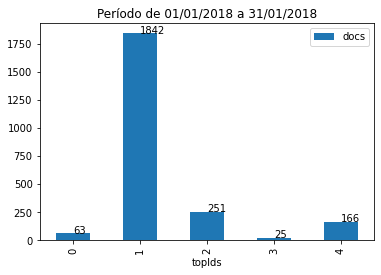





Calculando os 2 tópicos mais frequentes do período [01/02/2018 a 28/02/2018]
----------------------------------------
0 : ['ficar', 'mandar', 'eua', 'haitiana', 'comparar', 'pensar', 'tempo', 'tropa', 'merval_aqui', 'bolsonaro', 'antes', 'contratar_prostituta', 'rio_tuiuti', 'prostituta', 'mau', 'ong', 'forca', 'militar', 'acao', 'operacao']
1 : ['rio', 'onu', 'presidente', 'comandante', 'missao_paz', 'ajudar', 'contra', 'forca_armar', 'intervencao', 'general_heleno', 'governo', 'precisar', 'durante', 'estar', 'trabalhar', 'sugerir_levar', 'juiz_operacoes', 'sair', 'operacao', 'olhar']
2 : ['haitiano', 'gente', 'venezuela', 'grande', 'problema', 'exercito_brasileiro', 'parecer', 'entender', 'acoes', 'chamar', 'entrar', 'ficar', 'trabalhar', 'vida', 'situacao', 'colocar', 'hora', 'passar', 'povo', 'coisa']
3 : ['exercito', 'militar', 'general', 'brasileiro', 'povo', 'rio_janeiro', 'trabalho', 'usar', 'coisa', 'sexual', 'soldado', 'atuar', 'rua', 'passar', 'intervencao', 'acontecer',

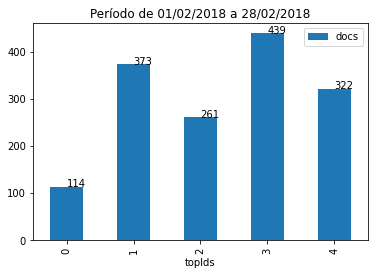





Calculando os 2 tópicos mais frequentes do período [01/03/2018 a 31/03/2018]
----------------------------------------
0 : ['passar', 'haitiana', 'guerra', 'vida', 'amigo', 'mundo', 'homem', 'tempo', 'crianco', 'esperar', 'mostrar', 'traduzir', 'primeiro', 'junto', 'verdade', 'mulher', 'colocar', 'gente', 'acontecer', 'parar']
1 : ['onu', 'ficar', 'pessoa', 'casa', 'contra', 'refugiar', 'conhecer', 'pedir', 'estar', 'cidade', 'conseguir', 'deixar', 'verdade', 'junto', 'forca_armar', 'intervencao', 'servir', 'rio_janeiro', 'populacao', 'ajudar']
2 : ['haitiano', 'negro', 'chegar', 'pensar', 'trabalhar', 'entender', 'branco', 'video', 'imigrante', 'kaysar', 'levar', 'lugar', 'perguntar', 'receber', 'sentir', 'comprar', 'parar', 'morrer', 'pessoa', 'coisa']
3 : ['terremoto', 'olhar', 'usar', 'viver', 'colocar', 'missao_paz', 'cuba', 'mexico', 'revolucao', 'forca_armar', 'eua', 'mau', 'paise', 'demais', 'acontecer', 'mulher', 'junto', 'problema', 'brasil', 'sirio']
4 : ['haiti', 'brasil

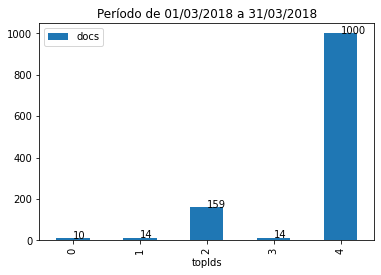





Calculando os 2 tópicos mais frequentes do período [01/04/2018 a 30/04/2018]
----------------------------------------
0 : ['haitiano', 'ficar', 'refugiar', 'kaysar', 'brasil', 'vender', 'venezuelano', 'branco', 'sirio', 'gente', 'sair', 'trabalhar', 'deixar', 'colocar', 'negro', 'traduzir', 'brasileiro', 'comprar', 'france', 'pessoa']
1 : ['haiti', 'brasil', 'exercito', 'usar', 'militar', 'vida', 'missao_paz', 'terremoto', 'mandar', 'missao', 'contar', 'precisar', 'cuba', 'chegar', 'musica', 'capitalista', 'apoio', 'trabalho', 'pegar', 'presidente']
2 : ['haiti', 'eua', 'gente', 'haitiana', 'lula', 'brasil', 'refugiar', 'receber', 'outro_paise', 'venezuela', 'virar', 'mexico', 'negro', 'cuba', 'meio', 'paise', 'perguntar', 'coisa', 'morar', 'conseguir']
3 : ['haiti', 'onu', 'brasil', 'escola', 'aluno', 'brasileiro', 'morrer', 'vender_livro', 'pedir', 'grupo', 'gostar', 'haitiano_radicar', 'republico', 'mae', 'conselho_seguranca', 'branco', 'financiar_moradia', 'esperar', 'orientaca

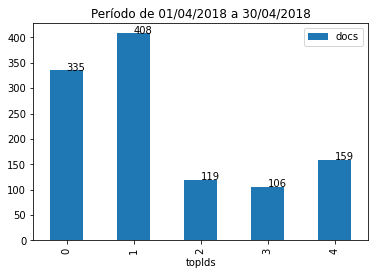





Calculando os 2 tópicos mais frequentes do período [01/05/2018 a 31/05/2018]
----------------------------------------
0 : ['argentina', 'copa', 'jogar', 'passar', 'gol', 'golear', 'primeiro', 'pegar', 'mundo', 'levar', 'amigo', 'higuain', 'vencer', 'perder', 'conseguir', 'chegar', 'casa', 'selecao', 'argentino', 'jogo']
1 : ['brasil', 'gente', 'bombonera', 'antes', 'terremoto', 'ontem', 'amistoso_contra', 'militar', 'exercito', 'vida', 'paz', 'acabar', 'tomar', 'mau', 'parecer', 'virar', 'casa', 'cuba', 'capitalista', 'facil']
2 : ['brasileiro', 'povo', 'ganhar', 'general', 'senhor', 'precisar', 'ajudar', 'deixar', 'missao', 'haitiana', 'sair', 'conseguir', 'direito', 'verdade', 'exercito', 'paz', 'facil', 'virar', 'tomar', 'olhar']
3 : ['contra', 'messi', 'selecao', 'jogo', 'grande', 'cuba', 'argentino', 'amistoso', 'fazer_gol', 'hat_trick', 'time', 'capitalista', 'olhar', 'momento', 'gostar_video', 'jamaica', 'facil', 'mundo', 'copa_mundo', 'futebol']
4 : ['haitiano', 'ficar', 'v

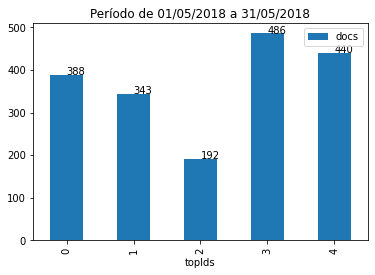





Calculando os 2 tópicos mais frequentes do período [01/06/2018 a 30/06/2018]
----------------------------------------
0 : ['copa', 'jogo', 'contra', 'argentina', 'jogar', 'time', 'messi', 'alemanha', 'jogador', 'selecoes', 'mundial', 'gol', 'amistoso', 'pegar', 'sul', 'fazer_gol', 'israel', 'amistoso_contra', 'copa_mundo', 'pessoal']
1 : ['haiti', 'brasil', 'brasileiro', 'selecao', 'povo', 'ficar', 'ajudar', 'futebol', 'pessoa', 'venezuela', 'coisa', 'chegar', 'chamar', 'torcer', 'paise', 'eua', 'militar', 'ganhar', 'selecao_brasileiro', 'trabalho']
2 : ['haitiano', 'passar', 'acabar', 'tentar', 'entrar', 'amigo', 'parecer', 'revolucao', 'olhar', 'vender', 'rua', 'junto', 'voltar', 'trabalho', 'ficar', 'imaginar', 'deixar', 'caso', 'ajudar', 'coisa']
3 : ['gente', 'grande', 'lembrar', 'lugar', 'video', 'viver', 'casa', 'negro', 'virar', 'galerar', 'vida', 'mundo', 'imaginar', 'momento', 'revolucao', 'trabalhar', 'morar', 'ficar', 'conhecer', 'olhar']
4 : ['mundo', 'primeiro', 'cuba

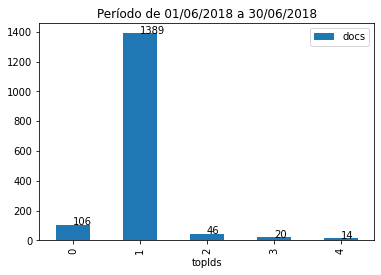





Calculando os 2 tópicos mais frequentes do período [01/07/2018 a 31/07/2018]
----------------------------------------
0 : ['brasil', 'governo', 'coisa', 'rua', 'haitiana', 'jogo', 'venezuela', 'povo', 'terremoto', 'protesto', 'musico', 'combustivel', 'selecao_brasileiro', 'eua', 'copa', 'olhar', 'viver', 'acabar', 'video', 'torcer']
1 : ['haiti', 'gente', 'brasileiro', 'jamaica', 'ficar', 'selecao', 'chorar', 'pessoa', 'mundo', 'paise', 'virar', 'torcer', 'olhar', 'deixar', 'vida', 'primeiro', 'copa', 'libano', 'selecao_brasileiro', 'viver']
2 : ['haitiano', 'the_voice', 'cantar', 'chegar', 'imigrante', 'amigo', 'pegar', 'filho', 'musica', 'acabar', 'voz', 'histor', 'chorar', 'historia', 'deixar', 'olhar', 'torcer_pra', 'moco', 'brasileiro', 'contar']
3 : ['primeiro_ministro', 'povo', 'contra', 'crise', 'trabalho', 'onu', 'ajudar', 'gostar', 'time', 'premie', 'protesto', 'combustivel', 'historia', 'brasileiro', 'haiti', 'historio', 'parecer', 'musico', 'contar', 'chegar']
4 : ['cub

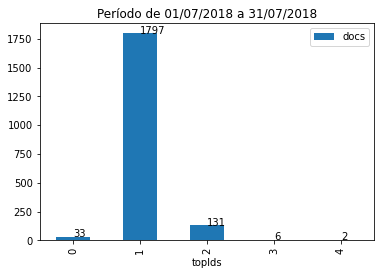





Calculando os 2 tópicos mais frequentes do período [01/08/2018 a 31/08/2018]
----------------------------------------
0 : ['haitiano', 'gente', 'coisa', 'passar', 'perguntar', 'amigo', 'haitiana', 'parar', 'revolucao', 'rua', 'conseguir', 'ouvir', 'pegar', 'olhar', 'primeiro', 'pensar', 'chamar', 'viver', 'pedir', 'homem']
1 : ['exercito', 'pacificar', 'mandar', 'exercito_brasileiro', 'acontecer', 'bolsonaro', 'presidente', 'virar', 'primeiro', 'arma', 'estar', 'tiro', 'atirar', 'seguranca', 'lembrar', 'lula', 'soldado', 'negro', 'pobre', 'qualquer']
2 : ['contra', 'venezuelano', 'pessoa', 'venezuela', 'deixar', 'mulher', 'povo', 'trabalhar', 'ganhar', 'sirio', 'negro', 'cantar', 'governo', 'programa', 'brasileiro', 'qualquer', 'estar', 'lembrar', 'vida', 'cuba']
3 : ['onu', 'ajudar', 'parecer', 'trabalho', 'precisar', 'acabar', 'curitiba', 'luciano_huck', 'guerra', 'morrer', 'candidato', 'jogar', 'servir', 'entender', 'mau', 'pobre', 'venezuela', 'lula', 'soldado', 'qualquer']
4 :

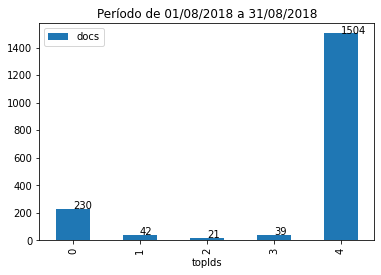





Calculando os 2 tópicos mais frequentes do período [01/09/2018 a 30/09/2018]
----------------------------------------
0 : ['haitiano', 'haitiana', 'trabalhar', 'chamar', 'japonesa', 'japonês', 'serena', 'ganhar', 'naomir_osaka', 'vencer', 'jogo', 'historia', 'parabem', 'final', 'open', 'sentir', 'negro', 'perder', 'revolucao', 'acontecer']
1 : ['haiti', 'brasileiro', 'passar', 'pessoa', 'missao_paz', 'contra', 'governo', 'mundo', 'missao', 'militar', 'capitalista', 'amigo', 'primeiro', 'exercito', 'parecer', 'paz', 'acabar', 'ficar', 'trabalho', 'argentina']
2 : ['haitiano', 'gente', 'voltar', 'venezuelano', 'rua', 'branco', 'por', 'filha', 'entender', 'mae_japonês', 'coisa', 'mae', 'ajudar', 'contar', 'tirar', 'mandar', 'pedir', 'ficar', 'casa', 'imigrante']
3 : ['onu', 'chegar', 'filho', 'igual', 'casa', 'conhecer', 'levar', 'povo', 'morar', 'situacao', 'amor', 'pegar', 'medo', 'lembrar', 'perguntar', 'encontrar', 'conseguir', 'morrer', 'usar', 'viver']
4 : ['brasil', 'venezuela'

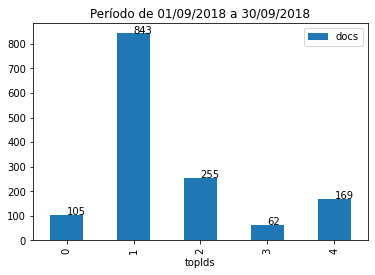





Calculando os 2 tópicos mais frequentes do período [01/10/2018 a 31/10/2018]
----------------------------------------
0 : ['haiti', 'grande', 'missao_paz', 'bolsonaro', 'capitalista', 'haitiana', 'governo', 'coisa', 'parecer', 'exercito', 'pensar', 'missao', 'general', 'paise', 'mostrar', 'levar', 'africar', 'olhar', 'onu', 'escola']
1 : ['haiti', 'terremoto', 'pessoa', 'ajudar', 'gente', 'negro', 'matar', 'acabar', 'vida', 'viver', 'comecar', 'casa', 'contar', 'caso', 'ontem', 'gostar', 'argentina', 'crianco', 'colocar', 'existir']
2 : ['haiti', 'povo', 'cuba', 'brasileiro', 'passar', 'militar', 'presidente', 'paz', 'conhecer', 'guerra', 'ganhar', 'norte', 'chamar', 'menos', 'acontecer', 'perder', 'noroeste', 'terremoto_magnitude', 'frente', 'matar']
3 : ['haitiano', 'ficar', 'brasileiro', 'centro', 'amigo', 'passar', 'conseguir', 'voltar', 'entender', 'imigrante', 'pegar', 'morar', 'familia', 'trabalhar', 'foto', 'branco', 'morrer', 'rua', 'trabalho', 'virar']
4 : ['haiti', 'bras

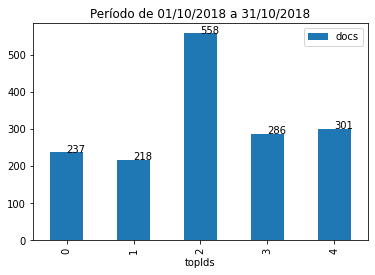





Calculando os 2 tópicos mais frequentes do período [01/11/2018 a 30/11/2018]
----------------------------------------
0 : ['haitiano', 'gente', 'conhecer', 'guerra', 'chamar', 'olhar', 'ficar', 'brasileiro', 'mostrar', 'perguntar', 'hora', 'entrar', 'comprar', 'mae', 'parabem', 'chegar', 'acabar', 'precisar', 'parecer', 'pensar']
1 : ['onu', 'militar', 'governo', 'general', 'brasileiro', 'missao', 'congo', 'venezuela', 'exercito', 'povo', 'haiti', 'missao_paz', 'levar', 'trabalho', 'familia', 'paz', 'bolsonaro', 'presidente', 'ficar', 'general_heleno']
2 : ['cuba', 'medico', 'paise', 'cubano', 'pagar', 'antes', 'medico_cubano', 'receber', 'programa', 'precisar', 'governo', 'paises', 'brasileiro', 'chegar_hora', 'zona_conflito', 'ilha', 'congo', 'gabeira', 'angolo', 'trazer']
3 : ['haiti', 'brasil', 'grande', 'ajudar', 'mundo', 'contra', 'eua', 'usar', 'coisa', 'deixar', 'rio', 'viver', 'lugar', 'corrupcao', 'tempo', 'estar', 'passar', 'mandar', 'existir', 'terremoto']
4 : ['haitian

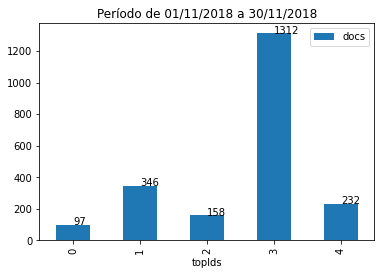





Calculando os 2 tópicos mais frequentes do período [01/12/2018 a 31/12/2018]
----------------------------------------
0 : ['ajudar', 'haitiana', 'negro', 'trabalhar', 'estar', 'branco', 'mae', 'publico', 'porto_alegre', 'natal', 'gente', 'contra', 'claro', 'deixar', 'caso', 'militar', 'revolucao', 'precisar', 'junto', 'acabar']
1 : ['chegar', 'general', 'filho', 'vida', 'familia', 'levar', 'refugiar', 'contar', 'aprender', 'morar', 'primeiro', 'historia', 'direito', 'presidente', 'precisar', 'governo', 'casa', 'brasil', 'ontem', 'mae']
2 : ['cuba', 'rua', 'voltar', 'paise', 'eua', 'mundo', 'paz', 'servir', 'apenas', 'virar', 'demais', 'igual', 'esperar', 'coisa', 'deixar', 'guerra', 'aprender', 'venezuela', 'gente', 'amigo']
3 : ['haiti', 'brasil', 'militar', 'brasileiro', 'imigrante', 'bolsonaro', 'haitiana_cega', 'governo', 'povo', 'aprovar_oab', 'congo', 'onu', 'venezuela', 'sobreviver_terremoto', 'terremoto', 'missao', 'general_heleno', 'presidente', 'exercito', 'precisar']
4 :

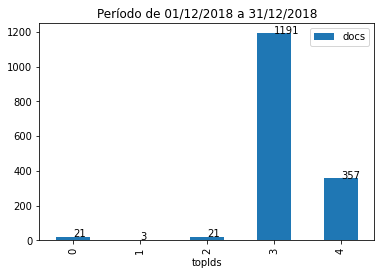





Calculando os 2 tópicos mais frequentes do período [01/01/2019 a 31/01/2019]
----------------------------------------
0 : ['haitiano', 'parecer', 'policial', 'conseguir', 'casa', 'morrer', 'contar', 'venezuelano', 'gente', 'pagar', 'povo', 'matar', 'pedir', 'haitiana', 'momento', 'chamar', 'familia', 'pegar', 'morar', 'entender']
1 : ['haiti', 'grande', 'venezuela', 'mundo', 'gente', 'pessoa', 'primeiro', 'revolucao', 'trabalho', 'pensar', 'guerra', 'chegar', 'janeiro', 'congo', 'continuar', 'povo', 'contra', 'negro', 'acontecer', 'governo']
2 : ['exercito', 'haiti', 'brasil', 'ajudar', 'militar', 'israel', 'governo', 'humanitario', 'vira', 'ajuda', 'bolsonaro', 'israelense', 'amigo', 'estar', 'tecnologia', 'bombeiro', 'encontrar', 'outro_paise', 'forca_armar', 'paz']
3 : ['haiti', 'terremoto', 'ajudar', 'brasileiro', 'exercito_brasileiro', 'militar', 'brumadinho', 'eua', 'atuar', 'precisar', 'mexico', 'missao', 'cuba', 'paise', 'israel', 'deixar', 'vida', 'trabalhar', 'politico', 

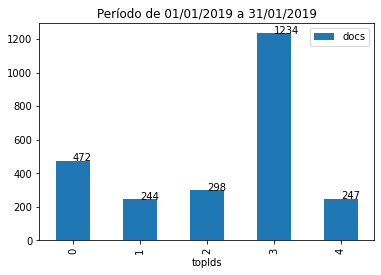

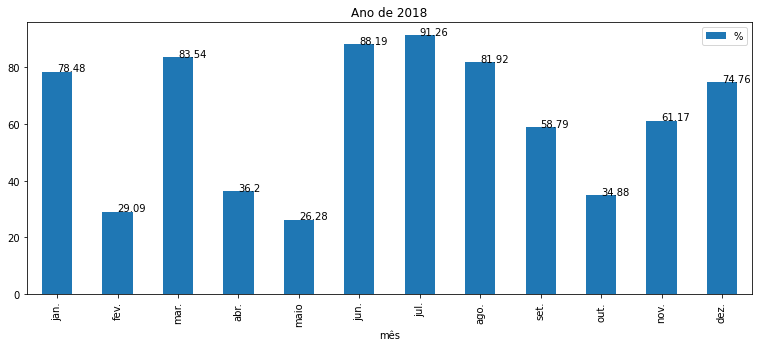




Calculando os 2 tópicos mais frequentes do período [01/02/2019 a 28/02/2019]
----------------------------------------
0 : ['brasileiro', 'presidente', 'gente', 'ajuda', 'pessoa', 'coisa', 'morrer', 'estar', 'parecer', 'chegar', 'levar', 'voltar', 'tomar', 'entrar', 'trabalho', 'entender', 'mandar', 'militar', 'exercito', 'viver']
1 : ['povo', 'governo', 'deixar', 'situacao', 'contra', 'usar', 'mau', 'guerra', 'exercito_brasileiro', 'venezuelano', 'populacao', 'ditador', 'continuar', 'vida', 'missao', 'por', 'maduro', 'apoiar', 'estar', 'viver']
2 : ['eua', 'petroleo', 'venezuela', 'humanitario', 'ajuda_humanitario', 'ajudar_humanitario', 'mundo', 'trump', 'mandar', 'paise', 'americano', 'crise', 'grande', 'precisar_ajuda', 'maduro', 'interesse', 'viver', 'africar', 'precisar', 'estados_unidos']
3 : ['haitiano', 'acontecer', 'protesto', 'senhor', 'matar', 'chamar', 'negro', 'tambem', 'contar', 'sair', 'meio', 'amigo', 'grande', 'presidente', 'esperar', 'antes', 'entender', 'viver', '

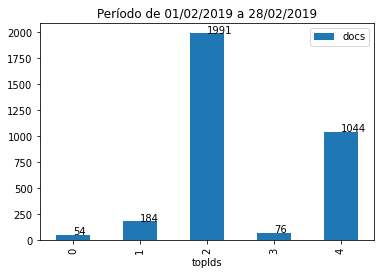





Calculando os 2 tópicos mais frequentes do período [01/03/2019 a 31/03/2019]
----------------------------------------
0 : ['haitiano', 'ficar', 'pessoa', 'amigo', 'coisa', 'gente', 'pensar', 'perguntar', 'chamar', 'venezuelano', 'revolucao', 'mulher', 'haitiana', 'vida', 'entender', 'conseguir', 'matar', 'gostar', 'americano', 'pedir']
1 : ['povo', 'passar', 'chegar', 'contra', 'problema', 'politico', 'acabar', 'mostrar', 'dinheiro', 'venezuelo', 'caso', 'contar', 'crise', 'estados_unidos', 'continuar', 'economia', 'trump', 'pagar', 'paise', 'morar']
2 : ['trabalhar', 'general', 'negro', 'trabalho', 'acontecer', 'branco', 'conhecer', 'familia', 'entrar', 'primeiro', 'rua', 'casa', 'viver', 'esperar', 'coisa', 'matar', 'conseguir', 'terremoto', 'estar', 'mandar']
3 : ['militar', 'brasileiro', 'onu', 'presidente', 'voltar', 'sair', 'exercito', 'mau', 'corrupcao', 'missao', 'menos', 'hora', 'olhar', 'situacao', 'continuar', 'missao_paz', 'lugar', 'crise', 'contar', 'politico']
4 : ['h

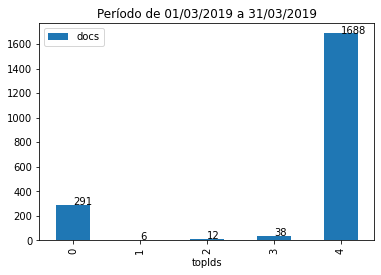





Calculando os 2 tópicos mais frequentes do período [01/04/2019 a 30/04/2019]
----------------------------------------
0 : ['brasil', 'exercito', 'militar', 'missao', 'general', 'bolsonaro', 'viver', 'precisar', 'lembrar', 'missao_paz', 'continuar', 'argentina', 'onu', 'parecer', 'igual', 'caso', 'familia', 'guerra', 'governo', 'paz']
1 : ['acabar', 'perguntar', 'entender', 'haitiana', 'revolucao', 'trabalhar', 'comecar', 'branco', 'primeiro', 'preciso', 'paz', 'parecer', 'conhecer', 'aprender', 'voltar', 'igual', 'precisar', 'negro', 'gente', 'triste']
2 : ['haiti', 'pessoa', 'gente', 'ajudar', 'ficar', 'mundo', 'brasileiro', 'mocambique', 'venezuela', 'coisa', 'negro', 'paise', 'eua', 'matar', 'povo', 'amigo', 'governo', 'acontecer', 'estar', 'cuba']
3 : ['haitiano', 'trabalho', 'pedir', 'caso', 'mulher', 'cada', 'centro', 'tentar', 'gostar', 'casa', 'ontem', 'ficar', 'aprender', 'amigo', 'igual', 'acontecer', 'receber', 'coisa', 'negro', 'chegar']
4 : ['pensar', 'passar', 'grande

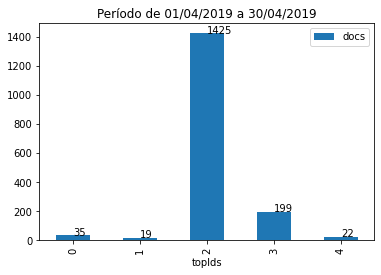





Calculando os 2 tópicos mais frequentes do período [01/05/2019 a 31/05/2019]
----------------------------------------
0 : ['haiti', 'brasil', 'brasileiro', 'venezuela', 'ficar', 'jovem', 'ajudar', 'grande', 'gente', 'governo', 'passar', 'cuba', 'coisa', 'deixar', 'sair', 'guerra', 'paise', 'olhar', 'politico', 'lugar']
1 : ['haitiano', 'chegar', 'chamar', 'casa', 'rua', 'perguntar', 'lado', 'gente', 'dinheiro', 'comprar', 'ouvir', 'colocar', 'parar', 'ontem', 'amigo', 'levar', 'filho', 'tomar', 'americano', 'acabar']
2 : ['mundo', 'revolucao', 'pensar', 'pessoa', 'negro', 'vida', 'conhecer', 'primeiro', 'haitiana', 'trabalho', 'levar', 'internacional', 'americano', 'homem', 'paz', 'familia', 'independencia', 'meio', 'deixar', 'forma']
3 : ['militar', 'congo', 'onu', 'general', 'presidente', 'bolsonaro', 'missao', 'missao_paz', 'santos_cruz', 'minustah', 'exercito', 'paz', 'lula', 'continuar', 'hondura', 'hora', 'general_santos', 'cruz', 'heleno', 'documento']
4 : ['eua', 'povo', 'm

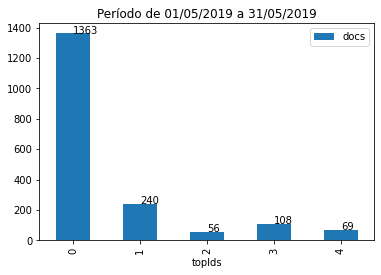





Calculando os 2 tópicos mais frequentes do período [01/06/2019 a 30/06/2019]
----------------------------------------
0 : ['onu', 'brasileiro', 'contra', 'lula', 'presidente', 'general', 'governo', 'ganhar', 'jogar', 'general_heleno', 'pobre', 'bolsonaro', 'militar', 'grande', 'negro', 'caso', 'civil', 'matar', 'de_este', 'politico']
1 : ['haitiano', 'heleno', 'ficar', 'passar', 'coisa', 'povo', 'deixar', 'matar', 'mulher', 'acontecer', 'amigo', 'morto', 'parecer', 'morte', 'olhar', 'casa', 'mundo', 'rua', 'cite_soleil', 'gente']
2 : ['pessoa', 'massacre', 'general_heleno', 'usar', 'ajudar', 'mandar', 'comandar', 'pegar', 'acabar', 'gente', 'conseguir', 'chegar', 'general', 'trabalhar', 'chamar', 'levar', 'trabalho', 'pensar', 'perguntar', 'matar']
3 : ['brasil', 'costa_rico', 'copa_ouro', 'grupo', 'jogo', 'eua', 'nicaragua', 'copa_americo', 'curacao', 'contra', 'vencer', 'venezuela', 'bermudar', 'bermudo', 'gol', 'virar', 'hondura', 'perder', 'cuba', 'mexico']
4 : ['general', 'lul

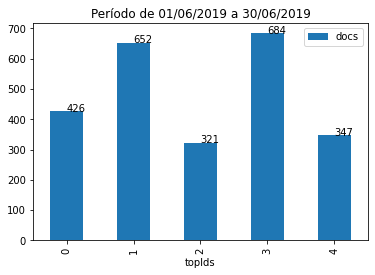





Calculando os 2 tópicos mais frequentes do período [01/07/2019 a 31/07/2019]
----------------------------------------
0 : ['haiti', 'brasil', 'mexico', 'virar', 'jogo', 'eua', 'copa_ouro', 'ouro', 'grande', 'perder', 'canado', 'canada', 'semifinal', 'primeiro', 'curacao', 'chegar', 'final', 'levar', 'futebol', 'ficar']
1 : ['contra', 'prorrogacao', 'selecao', 'costa_rico', 'negro', 'minuto', 'penalti', 'gostar', 'campanha', 'mexico', 'faltar', 'tomar', 'gol', 'precisar', 'conseguir', 'mexicano', 'final', 'copar_ouro', 'concacaf', 'historio']
2 : ['passar', 'bolsonaro', 'militar', 'gente', 'governo', 'general_heleno', 'coisa', 'vergonha', 'mau', 'haitiana', 'precisar', 'filho', 'esperar', 'olhar', 'ajudar', 'trabalho', 'chamar', 'contar', 'mulher', 'comecar']
3 : ['haitiano', 'acabar', 'amigo', 'revolucao', 'mae', 'casa', 'hora', 'familia', 'centro', 'pensar', 'gente', 'coisa', 'faltar', 'entender', 'ajudar', 'ficar', 'crianca', 'precisar', 'imigrante', 'parecer']
4 : ['brasileiro',

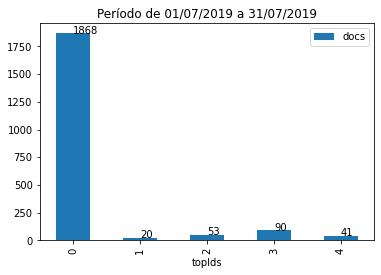





Calculando os 2 tópicos mais frequentes do período [01/08/2019 a 31/08/2019]
----------------------------------------
0 : ['amazonia', 'franco', 'cuidar', 'casa', 'viver', 'morar', 'sair', 'colonio', 'menos', 'congo', 'macron', 'guiano_francês', 'continuar', 'existir', 'miserio', 'colonia_francês', 'colonia', 'ficar', 'tentar', 'estudar']
1 : ['passar', 'pessoa', 'colonia_francês', 'haitiana', 'ouvir', 'ontem', 'caso', 'historia', 'politico', 'macronr', 'poder_ser', 'deixar_rastro', 'franca', 'viver', 'miserio', 'gravatai', 'africano', 'existir', 'roubar', 'deixar']
2 : ['haiti', 'brasil', 'brasileiro', 'chamar', 'presidente', 'mundo', 'governo', 'pobre', 'povo', 'general', 'paise', 'venezuela', 'militar', 'contra', 'lembrar', 'pensar', 'general_heleno', 'cuba', 'onu', 'parecer']
3 : ['haitiano', 'grande', 'ficar', 'gente', 'eua', 'revolucao', 'chegar', 'negro', 'voltar', 'trabalhar', 'coisa', 'conhecer', 'usar', 'matar', 'mulher', 'primeiro', 'mae', 'trabalho', 'vida', 'independen

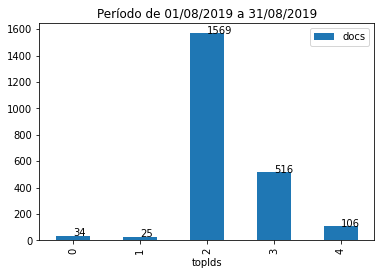





Calculando os 2 tópicos mais frequentes do período [01/09/2019 a 30/09/2019]
----------------------------------------
0 : ['haiti', 'general', 'brasileiro', 'pessoa', 'povo', 'deixar', 'contra', 'mundo', 'paise', 'coisa', 'venezuela', 'eua', 'governo', 'franco', 'ajudar', 'massacre', 'cuba', 'acontecer', 'amazonia', 'chegar']
1 : ['gente', 'negro', 'revolucao', 'pensar', 'branco', 'lugar', 'amigo', 'explicar', 'gostar', 'tentar', 'viver', 'preto', 'usar', 'sair', 'antes', 'tempo', 'povo', 'parecer', 'verdade', 'africar']
2 : ['senhor', 'passar', 'missao', 'vida', 'chamar', 'pedir', 'haitiana', 'tirar', 'verdade', 'lula', 'militar', 'comecar', 'exercito', 'dilma', 'massacre', 'mandar', 'contar', 'sair', 'ouvir', 'comandar']
3 : ['brasil', 'ficar', 'onu', 'matar', 'grande', 'militar', 'curacao', 'presidente', 'heleno', 'exercito', 'imagem', 'pobre', 'lula', 'morrer', 'general_heleno', 'porto_principe', 'dilma', 'crianca', 'antes', 'comecar']
4 : ['haitiano', 'acabar', 'olhar', 'esque

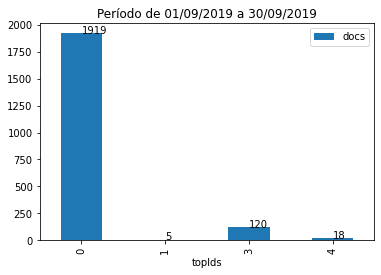





Calculando os 2 tópicos mais frequentes do período [01/10/2019 a 31/10/2019]
----------------------------------------
0 : ['haitiano', 'revolucao', 'amigo', 'negro', 'chamar', 'imigrante', 'casa', 'branco', 'acabar', 'conhecer', 'ganhar', 'contar', 'ontem', 'brasileiro', 'trabalhar', 'parecer', 'passar', 'morrer', 'morar', 'parar']
1 : ['ajudar', 'grupo', 'senhor', 'matar', 'lula', 'coisa', 'perder', 'voltar', 'pobre', 'estadio_serrinha', 'terremoto', 'goiania', 'haitiana', 'brasileiro', 'deixar', 'hora', 'seguir', 'bolsonaro', 'vida', 'trabalhar']
2 : ['povo', 'governo', 'contra', 'argentina', 'hondura', 'lutar', 'paise', 'peru', 'mexico', 'independencia', 'neoliberal', 'popular', 'equador_chile', 'direito', 'brasileiro', 'politico', 'china', 'americo_latina', 'conhecer', 'chilar_equador']
3 : ['pessoa', 'jogo', 'viver', 'primeiro', 'tempo', 'comecar', 'coreiar_sul', 'lembrar', 'politico', 'franco', 'africar', 'internacional', 'situacao', 'missao_paz', 'rodar', 'seguir', 'deixar',

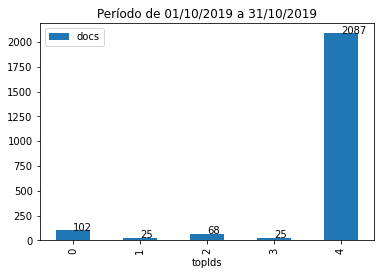





Calculando os 2 tópicos mais frequentes do período [01/11/2019 a 30/11/2019]
----------------------------------------
0 : ['haiti', 'brasil', 'militar', 'equador', 'chiler', 'boliver', 'franco', 'haitiana', 'lembrar', 'venezuela', 'ajudar', 'protesto', 'grupo', 'deixar', 'americo_latino', 'jogo', 'franca', 'selecao', 'argentina', 'gostar']
1 : ['haiti', 'heleno', 'contra', 'eua', 'negro', 'cuba', 'mundo', 'pensar', 'paise', 'pobre', 'onu', 'rodar', 'costa_rico', 'chile', 'tempo', 'grupo_copa', 'histor', 'mostrar', 'assassino', 'primeiro']
2 : ['haiti', 'general', 'povo', 'brasileiro', 'lula', 'governo', 'mandar', 'massacre', 'sair', 'pessoa', 'matar', 'ficar', 'presidente', 'senhor', 'rua', 'bolsonaro', 'morto', 'exercito', 'trabalho', 'onu']
3 : ['haitiano', 'revolucao', 'chegar', 'perguntar', 'mulher', 'sobre_revolucao', 'ouvir', 'branco', 'passar', 'ficar', 'gente', 'hora', 'homem', 'negro', 'trabalhar', 'pessoa', 'casa', 'filho', 'tentar', 'amigo']
4 : ['haiti', 'coisa', 'chama

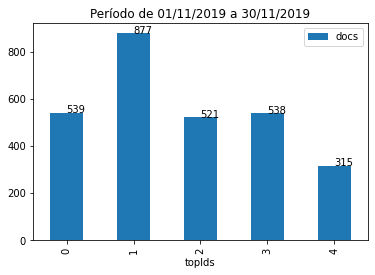





Calculando os 2 tópicos mais frequentes do período [01/12/2019 a 31/12/2019]
----------------------------------------
0 : ['brasileiro', 'militar', 'crianco', 'missao_paz', 'minustah', 'abandonar', 'acusar_estupro', 'tempo', 'menina', 'filho', 'senhor', 'general_heleno', 'menos', 'missao', 'sair', 'americano', 'forco_paz', 'soldado', 'onu', 'mulher']
1 : ['povo', 'grande', 'lembrar', 'levar', 'amigo', 'esperar', 'precisar', 'contar', 'acabar', 'matar', 'chiler', 'trabalho', 'continuar', 'mau', 'senhor', 'rua', 'presidente', 'franco', 'hora', 'tentar']
2 : ['governo', 'estar', 'deixar', 'general', 'haitiana', 'politico', 'capitalismo', 'existir', 'lula', 'lugar', 'presidente', 'caso', 'china', 'estado', 'caetano_veloso', 'primeiro', 'senhor', 'mau', 'viver', 'perguntar']
3 : ['haitiano', 'ficar', 'gente', 'passar', 'revolucao', 'trabalhar', 'conseguir', 'entender', 'chamar', 'comecar', 'primeiro', 'rua', 'pedir', 'ganhar', 'olhar', 'tirar', 'sair', 'conversar', 'casa', 'ontem']
4 : 

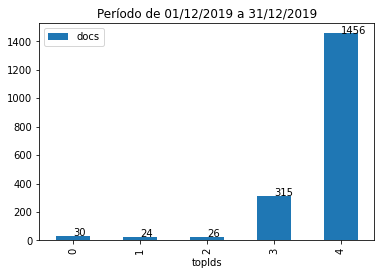





Calculando os 2 tópicos mais frequentes do período [01/01/2020 a 31/01/2020]
----------------------------------------
0 : ['brasileiro', 'terremoto', 'militar', 'deixar', 'filho', 'ajudar', 'morrer', 'olhar', 'sair', 'crianco', 'dez_ano', 'missao_paz', 'mulher', 'parecer', 'familia', 'perguntar', 'mostrar', 'mau', 'vida', 'acabar']
1 : ['brasil', 'ficar', 'grande', 'pessoa', 'eua', 'mundo', 'passar', 'janeiro', 'primeiro', 'coisa', 'tropa', 'amigo', 'acontecer', 'real', 'cuba', 'gostar', 'morte', 'ira', 'independencia', 'levar']
2 : ['general', 'massacre', 'missao', 'filme', 'governo', 'general_heleno', 'filme_sobre', 'terror', 'precisar', 'haitiana', 'exercito_brasileiro', 'documentario_sobre', 'comandar', 'verdade', 'documentario', 'livro', 'estupro', 'soldado', 'ocorrer', 'explicar']
3 : ['haitiano', 'revolucao', 'gente', 'povo', 'chamar', 'mandar', 'chegar', 'presidente', 'negro', 'usar', 'trabalho', 'entender', 'vida', 'tempo', 'comecar', 'colocar', 'ler', 'conhecer', 'pedir',

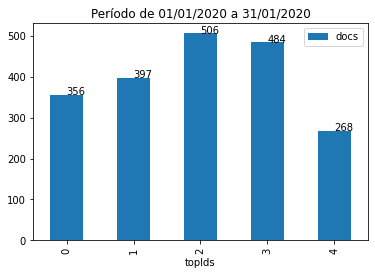

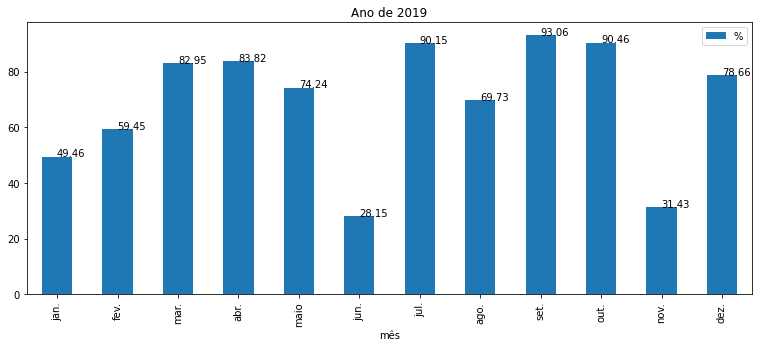




Calculando os 2 tópicos mais frequentes do período [01/02/2020 a 29/02/2020]
----------------------------------------
0 : ['haitiano', 'passar', 'ligar', 'esquecer', 'entender', 'acabar', 'hora', 'estar', 'ajudar', 'levar', 'conseguir', 'virar', 'perder', 'mulher', 'coisa', 'ficar', 'gente', 'amigo', 'negro', 'vida']
1 : ['brasil', 'governo', 'onu', 'pensar', 'lembrar', 'missao', 'morte', 'crime', 'casa', 'comandar', 'precisar', 'mulher_crianco', 'perguntar', 'genocir', 'heleno', 'exercito_brasileiro', 'missao_paz', 'bolsonaro', 'miliciano', 'estar']
2 : ['baile', 'pessoa', 'grande', 'chegar', 'esperar', 'coisa', 'pegar', 'mundo', 'contar', 'caso', 'lugar', 'contra', 'sair', 'ficar', 'hora', 'mulher', 'carnaval', 'vida', 'lembrar', 'negro']
3 : ['general', 'matar', 'massacre', 'receber', 'papa', 'assassino', 'senhor', 'crianco', 'miliciano', 'exercito', 'mandar', 'explicar', 'amigo', 'velho', 'gostar', 'pobre', 'carnaval', 'trabalhar', 'sair', 'morrer']
4 : ['lula', 'heleno', 'ficar

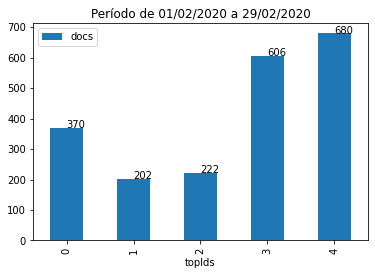





Calculando os 2 tópicos mais frequentes do período [01/03/2020 a 31/03/2020]
----------------------------------------
0 : ['haiti', 'volta', 'voltar_pro', 'volta_pro', 'mundo', 'estar', 'ajudar', 'gostar', 'lugar', 'levar', 'primeiro', 'brasil', 'pegar', 'idiota', 'mandar', 'receber', 'viver', 'dever_ter', 'casa', 'sair']
1 : ['haitiano', 'presidente', 'bolsonaro', 'brasil', 'brasileiro', 'mandar', 'ficar', 'governo', 'bolsonaro_acabar', 'sair', 'entender', 'pessoa', 'casa', 'video', 'grande', 'ouvir', 'contra', 'deixar', 'levar', 'alguem']
2 : ['povo', 'precisar', 'verdade', 'coragem', 'estrangeiro', 'matar', 'cair', 'tempo', 'parecer', 'parabem', 'brasileiro', 'ouvir', 'homem', 'alguem', 'faltar', 'politico', 'primeiro', 'rapaz', 'jornalista', 'ficar']
3 : ['acabar', 'bozo', 'coisa', 'chegar', 'imigrante', 'cidadao', 'direito', 'certo', 'olhar', 'governo', 'receber', 'ficar', 'video', 'entender', 'esperar', 'politico', 'presidente', 'pessoa', 'deixar', 'primeiro']
4 : ['voltar', 

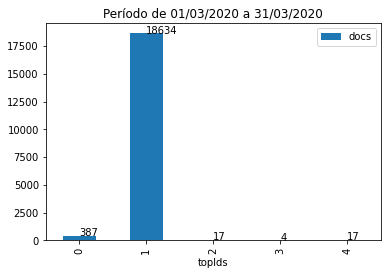





Calculando os 2 tópicos mais frequentes do período [01/04/2020 a 30/04/2020]
----------------------------------------
0 : ['verdade', 'mundo', 'sair', 'video', 'amigo', 'moro', 'alguem', 'olhar', 'antes', 'povo', 'pensar', 'cair', 'entender', 'chamar', 'mandetta', 'politico', 'bolsonaro_acabar', 'bozo', 'parecer', 'ficar']
1 : ['haiti', 'brasil', 'ficar', 'passar', 'povo', 'militar', 'terremoto', 'pensar', 'deixar', 'coisa', 'acontecer', 'matar', 'contra', 'conseguir', 'ajudar', 'chiler', 'contar', 'covid', 'gostar', 'estar']
2 : ['haitiano', 'presidente', 'bolsonaro', 'acabar', 'governo', 'bolsonaro_acabar', 'vir_futuro', 'futuro', 'brasileiro', 'razao', 'bozo', 'lembrar', 'tempo', 'profeta_haitiano', 'chamar', 'precisar', 'senhor', 'usar', 'politico', 'voltar']
3 : ['certo', 'acabar_bolsonaro', 'avisar', 'mandar', 'casa', 'conseguir', 'militar', 'presidente', 'ficar', 'haitiano', 'bolsonaro', 'mandetta', 'cair', 'profeta_haitiano', 'bozo', 'acabar', 'governo', 'razao', 'ouvir', '

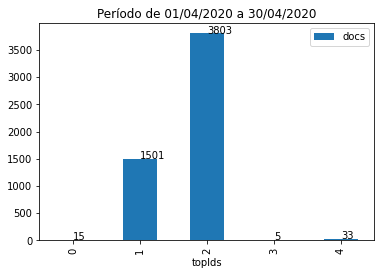





Calculando os 2 tópicos mais frequentes do período [01/05/2020 a 31/05/2020]
----------------------------------------
0 : ['ficar', 'pessoa', 'voltar', 'conhecer', 'estar', 'vergonha', 'eua', 'vida', 'olhar', 'contar', 'vir_futuro', 'colocar', 'esperar', 'casa', 'negro', 'ouvir', 'futuro', 'chegar', 'haiti', 'precisar']
1 : ['brasil', 'general', 'militar', 'grande', 'contra', 'exercito', 'genocir', 'mundo', 'ajudar', 'levar', 'caso', 'usar', 'merda', 'venezuela', 'haitiana', 'genocidio', 'estar', 'haiti', 'velho', 'antes']
2 : ['acabar', 'gente', 'pensar', 'amigo', 'coisa', 'chamar', 'paise', 'pobre', 'cuba', 'acontecer', 'homem', 'igual', 'eua', 'entrar', 'tempo', 'bozo', 'conseguir', 'certo', 'haitiano', 'venezuela']
3 : ['haiti', 'haitiano', 'presidente', 'bolsonaro', 'governo', 'brasileiro', 'povo', 'lembrar', 'revolucao', 'tempo', 'bozo', 'mandar', 'senhor', 'sair', 'futuro', 'precisar', 'negro', 'bolsonaro_acabar', 'deixar', 'assassino']
4 : ['heleno', 'general_heleno', 'onu'

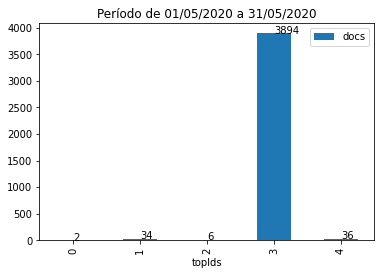





Calculando os 2 tópicos mais frequentes do período [01/06/2020 a 30/06/2020]
----------------------------------------
0 : ['haitiano', 'acabar', 'governo', 'sair', 'mandar', 'chegar', 'caso', 'precisar', 'filipinas_suriname', 'esperar', 'coisa', 'perguntar', 'preto', 'futuro', 'mostrar', 'pedir', 'alguem', 'grande', 'acontecer', 'morte']
1 : ['haitiano', 'presidente', 'revolucao', 'negro', 'bolsonaro', 'branco', 'lembrar', 'primeiro', 'bolsonaro_acabar', 'cair', 'comecar', 'ficar', 'mulher', 'casa', 'sobre_revolucao', 'gente', 'chamar', 'francês', 'conseguir', 'grande']
2 : ['haiti', 'brasil', 'republico_dominicano', 'panamar', 'colomber_equador', 'trinidad_tobago', 'paise', 'suriname_trinidad', 'banco_mundial', 'grupo', 'passar', 'vida', 'terremoto', 'parecer', 'weintraub', 'grande', 'deixar', 'historio', 'conseguir', 'pedir']
3 : ['haiti', 'mundo', 'eua', 'ajudar', 'pessoa', 'tempo', 'haitiana', 'independencia', 'amigo', 'morrer', 'ouvir', 'historia', 'venezuela', 'medo', 'trabal

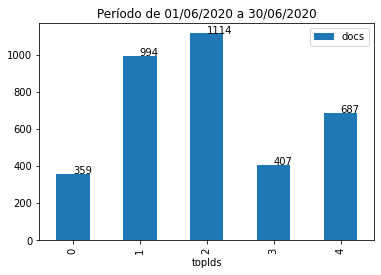





Calculando os 2 tópicos mais frequentes do período [01/07/2020 a 31/07/2020]
----------------------------------------
0 : ['brasil', 'gente', 'pensar', 'chamar', 'coisa', 'primeiro', 'chegar', 'antes', 'mostrar', 'americano', 'histor', 'politico', 'verdade', 'sair', 'vario', 'preto', 'conhecer', 'americo', 'china', 'mundo']
1 : ['haitiano', 'revolucao', 'haitiana', 'sobre_revolucao', 'historia', 'mulher', 'casa', 'vodu', 'vida', 'livro', 'gostar', 'ouvir', 'historico', 'pedir', 'historio', 'unico', 'estados_unidos', 'coisa', 'amigo', 'verdade']
2 : ['haiti', 'ficar', 'eua', 'brasileiro', 'grande', 'povo', 'governo', 'general', 'matar', 'ajudar', 'genocidio', 'trabalho', 'lembrar', 'entender', 'deixar', 'guerra', 'amigo', 'acontecer', 'onu', 'tempo']
3 : ['negro', 'branco', 'militar', 'paise', 'cuba', 'mundo', 'venezuela', 'pobre', 'exercito', 'lugar', 'morrer', 'usar', 'estar', 'rico', 'mandar', 'existir', 'video', 'criar', 'unico', 'fazer_parte']
4 : ['acabar', 'bolsonaro', 'presi

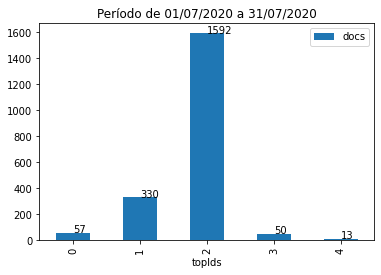





Calculando os 2 tópicos mais frequentes do período [01/08/2020 a 31/08/2020]
----------------------------------------
0 : ['revolucao', 'chamar', 'haitiana', 'pensar', 'texto', 'coisa', 'gostar', 'americo', 'livro', 'francês', 'africano', 'olhar', 'tentar', 'mulher', 'meio', 'ler', 'pedir', 'chegar', 'primeiro', 'conhecer']
1 : ['negro', 'ficar', 'acabar', 'contra', 'branco', 'presidente', 'vida', 'perguntar', 'africano', 'general', 'pica_pau', 'levar', 'mulher', 'matar', 'mau', 'bolsonaro', 'sair', 'contar', 'pedir', 'meio']
2 : ['paise', 'ajudar', 'grupo', 'brasil', 'tobago', 'independencia', 'suriname_trinidad', 'menos', 'panamar_filipina', 'dominicana_equador', 'colomber_republico', 'tempo', 'escravidao', 'representar', 'levar', 'agosto', 'primeiro', 'bolsonaro', 'haiti', 'franco']
3 : ['haiti', 'brasil', 'cuba', 'pessoa', 'mundo', 'eua', 'gente', 'republico_dominicano', 'grande', 'senhor', 'terremoto', 'povo', 'brasileiro', 'primeiro', 'passar', 'acontecer', 'chegar', 'baile',

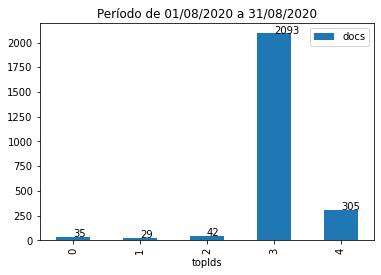





Calculando os 2 tópicos mais frequentes do período [01/09/2020 a 30/09/2020]
----------------------------------------
0 : ['ficar', 'eua', 'chamar', 'presidente', 'independencia', 'primeiro', 'guerra', 'acabar', 'precisar', 'antes', 'livro', 'tempo', 'ajudar', 'americo', 'homem', 'conseguir', 'igual', 'escravidao', 'trabalhar', 'colocar']
1 : ['viver', 'povo', 'historia', 'mundo', 'contar', 'cuba', 'exercito', 'usar', 'paise', 'histor', 'casa', 'lula', 'mau', 'problema', 'servir', 'esperar', 'parecer', 'acabar', 'historio', 'politico']
2 : ['haiti', 'brasil', 'negro', 'brasileiro', 'gente', 'matar', 'grande', 'militar', 'pessoa', 'pobre', 'lembrar', 'contra', 'general_heleno', 'missao', 'pensar', 'heleno', 'historio', 'bolsonaro', 'senhor', 'onu']
3 : ['haitiano', 'revolucao', 'vida', 'branco', 'trabalho', 'voltar', 'existir', 'mulher', 'rua', 'parecer', 'negro', 'acabar', 'gostar', 'liberal', 'pessoa', 'pensar', 'gente', 'contra', 'ler', 'brasileiro']
4 : ['general', 'governo', 'p

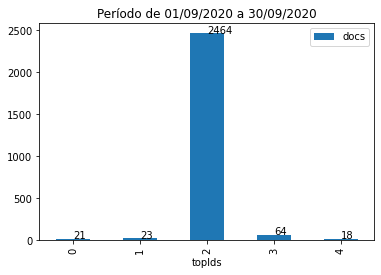





Calculando os 2 tópicos mais frequentes do período [01/10/2020 a 31/10/2020]
----------------------------------------
0 : ['haiti', 'passar', 'eua', 'deixar', 'ficar', 'povo', 'olhar', 'antes', 'tornar', 'acontecer', 'lugar', 'contra', 'presidente', 'ajudar', 'cuba', 'lembrar', 'tempo', 'estado', 'boliver', 'morrer']
1 : ['haiti', 'mundo', 'hondura', 'paise', 'americo_latino', 'branco', 'acabar', 'direito', 'conseguir', 'unico', 'existir', 'vender', 'estar', 'apenas', 'vario', 'continuar', 'cuba', 'chegar', 'pessoa', 'trabalhar']
2 : ['haiti', 'brasileiro', 'mau', 'heleno', 'general', 'onu', 'general_heleno', 'militar', 'jogar', 'crianco', 'morte', 'matar', 'gente', 'levar', 'estupro', 'massacre', 'governo', 'amigo', 'pessoa', 'mandar']
3 : ['haitiano', 'revolucao', 'chamar', 'lado', 'haitiana', 'trabalho', 'pensar', 'pedir', 'primeiro', 'casa', 'gente', 'presidente', 'americano', 'ficar', 'tomar', 'contra', 'mulher', 'pessoa', 'tempo', 'negro']
4 : ['haiti', 'brasil', 'venezuela',

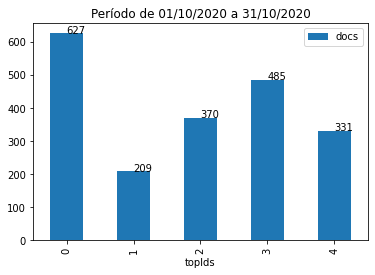





Calculando os 2 tópicos mais frequentes do período [01/11/2020 a 30/11/2020]
----------------------------------------
0 : ['haitiano', 'revolucao', 'acabar', 'deixar', 'mae', 'trabalhar', 'mulher', 'pedir', 'trump', 'preto', 'meio', 'passar', 'presidente', 'ajudar', 'sair', 'voltar', 'levar', 'conhecer', 'coisa', 'gostar']
1 : ['negro', 'povo', 'branco', 'grande', 'matar', 'americano', 'usar', 'antes', 'amigo', 'escravo', 'chamar', 'racismo', 'trabalhar', 'medo', 'gostar', 'pessoa', 'brasileiro', 'precisar', 'qualquer', 'coisa']
2 : ['ficar', 'general', 'cuba', 'lembrar', 'bolsonaro', 'haitiana', 'exercito', 'igual', 'primeiro', 'precisar', 'unico', 'pagar', 'conseguir', 'medo', 'independencia', 'lugar', 'filho', 'qualquer', 'chamar', 'demais']
3 : ['haiti', 'brasil', 'eua', 'brasileiro', 'mundo', 'chegar', 'paise', 'pessoa', 'venezuela', 'pensar', 'onu', 'militar', 'viver', 'passar', 'vida', 'acontecer', 'sair', 'china', 'governo', 'voltar']
4 : ['gente', 'contra', 'guerra', 'exis

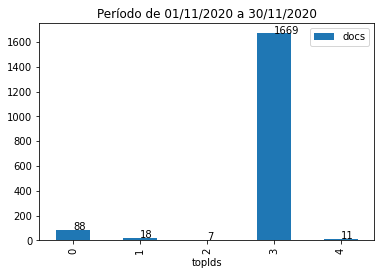





Calculando os 2 tópicos mais frequentes do período [01/12/2020 a 31/12/2020]
----------------------------------------
0 : ['haitiano', 'acabar', 'ficar', 'pessoa', 'chamar', 'pensar', 'pedir', 'mandar', 'mae', 'parecer', 'sair', 'comprar', 'historia', 'trazer', 'perguntar', 'americo_latino', 'livro', 'chegar', 'casa', 'imigrante']
1 : ['brasileiro', 'grande', 'eua', 'contra', 'mundo', 'lembrar', 'general_heleno', 'matar', 'haitiana', 'baile', 'precisar', 'contar', 'politico', 'ganhar', 'tempo', 'minustah', 'cidade', 'pequeno', 'imigrante', 'guerra']
2 : ['povo', 'cuba', 'presidente', 'deixar', 'trabalho', 'amigo', 'dinheiro', 'levar', 'rua', 'gostar', 'medo', 'africar', 'mau', 'tomar', 'tempo', 'ficar', 'minustah', 'livro', 'pobre', 'bozo']
3 : ['haiti', 'brasil', 'gente', 'general', 'governo', 'heleno', 'bolsonaro', 'paise', 'negro', 'venezuela', 'militar', 'chegar', 'onu', 'exercito', 'conseguir', 'conhecer', 'estar', 'olhar', 'primeiro', 'familia']
4 : ['revolucao', 'ajudar', 'p

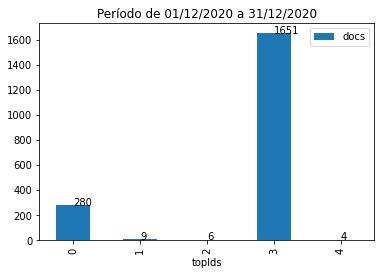





Calculando os 2 tópicos mais frequentes do período [01/01/2021 a 31/01/2021]
----------------------------------------
0 : ['haiti', 'brasileiro', 'grande', 'povo', 'independencia', 'ficar', 'primeiro', 'cuba', 'militar', 'governo', 'janeiro', 'exercito', 'matar', 'baile', 'paise', 'tempo', 'heleno', 'eua', 'usar', 'general']
1 : ['favor_ajudar', 'ajudar', 'favor', 'pequeno', 'brasil', 'salario_minimo', 'argentina', 'trazer_filha', 'brasileiro', 'filha', 'facil_favor', 'trazer', 'mulher', 'antes', 'conhecer', 'coisa', 'chegar', 'trabalhar', 'haiti', 'pessoa']
2 : ['haitiano', 'presidente', 'bolsonaro', 'gente', 'pessoa', 'acabar', 'chamar', 'voodoo', 'igual', 'gostar', 'casa', 'comprar', 'governo', 'olhar', 'tempo', 'ficar', 'tomar', 'matar', 'trabalhar', 'mulher']
3 : ['brasil', 'passar', 'lembrar', 'acabar', 'precisar', 'mundo', 'vida', 'sair', 'estar', 'pedir', 'tornar', 'contar', 'onu', 'governo', 'mandar', 'grande', 'venezuela', 'mau', 'guerra', 'tempo']
4 : ['revolucao', 'negr

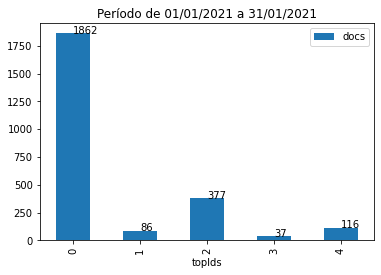

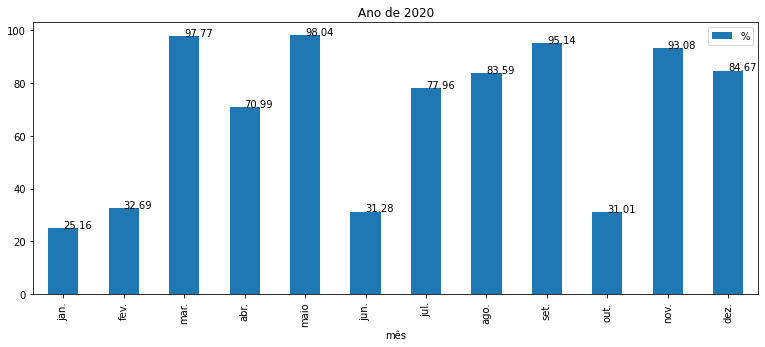




Calculando os 2 tópicos mais frequentes do período [01/02/2021 a 28/02/2021]
----------------------------------------
0 : ['haitiano', 'povo', 'pessoa', 'mundo', 'imigrante', 'apoiar', 'rua', 'deixar', 'viver', 'equador', 'peru', 'jovenel_moise', 'morrer', 'domingo', 'perguntar', 'brasileiro', 'chegar', 'acontecer', 'acabar', 'contra']
1 : ['estar', 'cuba', 'acabar', 'negro', 'coisa', 'golpe', 'exercito', 'sair', 'ajudar', 'chamar', 'parecer', 'levar', 'virar', 'exercito_brasileiro', 'casa', 'cidade', 'paise', 'acontecer', 'deixar', 'politico']
2 : ['brasileiro', 'revolucao', 'general', 'militar', 'mandar', 'pensar', 'passar', 'tempo', 'precisar', 'populacao', 'guerra', 'mulher', 'voltar', 'caso', 'politico', 'estado', 'meio', 'missao', 'pedir', 'missao_paz']
3 : ['vencer', 'teste', 'querer_doar', 'milhao_teste', 'doar', 'covid', 'gente', 'quase_vencer', 'enviar', 'teste_covid', 'usar', 'covid_quase', 'incompetencia', 'pazuello_querer', 'doar_teste', 'vergonha', 'pazuello', 'deixar'

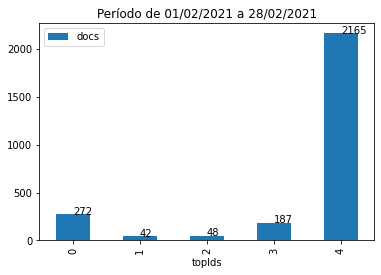





Calculando os 2 tópicos mais frequentes do período [01/03/2021 a 31/03/2021]
----------------------------------------
0 : ['haitiano', 'presidente', 'bolsonaro', 'acabar', 'revolucao', 'lembrar', 'chamar', 'mulher', 'certo', 'pegar', 'bolsonaro_acabar', 'imigrante', 'levar', 'matar', 'negro', 'video', 'comecar', 'brasileiro', 'verdade', 'primeiro']
1 : ['povo', 'precisar', 'lula', 'mandar', 'acontecer', 'ajudar', 'mau', 'pedir', 'missao', 'apenas', 'matar', 'negro', 'contra', 'exercito', 'mundo', 'apoiar', 'estar', 'pobre', 'levar', 'general']
2 : ['gente', 'contra', 'pessoa', 'tempo', 'grupo', 'paise', 'haitiana', 'hondura', 'jogo', 'sair', 'pre_olimpico', 'contar', 'parar', 'chegar', 'comecar', 'selecao', 'levar', 'primeiro', 'covid', 'jogar']
3 : ['haiti', 'brasil', 'governo', 'brasileiro', 'ficar', 'eua', 'grande', 'mundo', 'cuba', 'venezuela', 'passar', 'onu', 'deixar', 'pensar', 'primeiro', 'amigo', 'general', 'politico', 'exercito', 'estar']
4 : ['militar', 'antes', 'coisa',

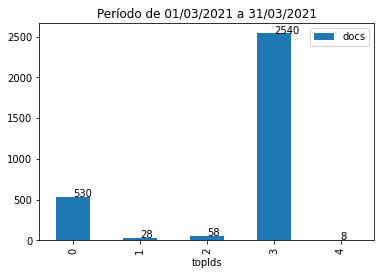





Calculando os 2 tópicos mais frequentes do período [01/04/2021 a 30/04/2021]
----------------------------------------
0 : ['crianco_africana', 'ajudar', 'feliciano', 'negro', 'guerra', 'amigo', 'levar', 'africana', 'chamar', 'lugar', 'igreja', 'pastor', 'dinheiro', 'pedir', 'parar', 'afeganistao', 'usar', 'crianca', 'politico', 'africo']
1 : ['haiti', 'brasil', 'brasileiro', 'ficar', 'povo', 'paise', 'eua', 'cuba', 'missao', 'deixar', 'mau', 'pensar', 'ficar_africo', 'coisa', 'precisar', 'lula', 'politico', 'africano', 'olhar', 'crianca']
2 : ['bolsonaro', 'governo', 'mundo', 'grande', 'pessoa', 'acabar', 'presidente', 'militar', 'contra', 'exercito', 'mandar', 'heleno', 'pedir', 'haitiana', 'tentar', 'tempo', 'defender', 'onu', 'continuar', 'lula']
3 : ['haitiano', 'gente', 'revolucao', 'chegar', 'passar', 'lembrar', 'matar', 'entender', 'historia', 'parar', 'caso', 'sair', 'primeiro', 'povo', 'coisa', 'precisar', 'antes', 'olhar', 'usar', 'voltar']
4 : ['venezuela', 'africar', 'g

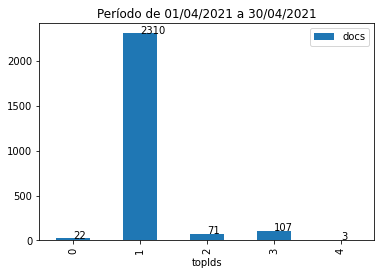





Calculando os 2 tópicos mais frequentes do período [01/05/2021 a 31/05/2021]
----------------------------------------
0 : ['presidente', 'governo', 'brasileiro', 'bolsonaro', 'rua', 'heleno', 'mandar', 'usar', 'chamar', 'chegar', 'levar', 'mostrar', 'deixar', 'pessoa', 'general', 'onu', 'vida', 'lembrar', 'militar', 'matar']
1 : ['haitiano', 'acabar', 'gente', 'coisa', 'pessoa', 'tentar', 'sobre_revolucao', 'trabalho', 'venezuelano', 'situacao', 'governo', 'revolucao', 'chegar', 'comecar', 'amigo', 'olhar', 'ouvir', 'mulher', 'matar', 'entender']
2 : ['brasil', 'ficar', 'eua', 'negro', 'lembrar', 'cuba', 'paise', 'venezuela', 'missao', 'precisar', 'conseguir', 'politico', 'virar', 'morar', 'colocar', 'parte', 'vida', 'estar', 'unico', 'terremoto']
3 : ['mundo', 'exercito', 'contra', 'acontecer', 'pobre', 'militar', 'onu', 'deixar', 'perguntar', 'primeiro', 'futuro', 'antes', 'unico', 'politico', 'ajudar', 'existir', 'morte', 'mulher', 'grande', 'comecar']
4 : ['haiti', 'revolucao',

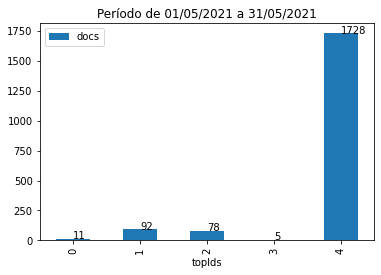





Calculando os 2 tópicos mais frequentes do período [01/06/2021 a 30/06/2021]
----------------------------------------
0 : ['selecao', 'jogo', 'canado', 'passar', 'exercito', 'gol', 'canada', 'deixar', 'jogar', 'copa_americo', 'costa_rico', 'caso', 'time', 'mexico', 'hondura', 'nicaragua', 'copa', 'eua', 'voltar', 'futebol']
1 : ['presidente', 'bolsonaro', 'pessoa', 'cair', 'negro', 'nicaragua', 'amigo', 'comecar', 'ouvir', 'pensar', 'governo', 'hora', 'parecer', 'colocar', 'bolsonaro_acabar', 'precisar', 'gente', 'lembrar', 'conseguir', 'acabar_bolsonaro']
2 : ['goleiro', 'salvador', 'grupo', 'mundo', 'sao_cristovao', 'olhar', 'curacao', 'lula', 'pensar', 'eliminatoria_concacaf', 'usar', 'canada', 'canado', 'copa', 'eua', 'ganhar', 'historia', 'apenas', 'haiti', 'nicaragua']
3 : ['haitiano', 'acabar', 'ficar', 'tempo', 'acabar_bolsonaro', 'video', 'futuro', 'vir_futuro', 'bolsonaro_acabar', 'governo', 'lembrar', 'voltar', 'mulher', 'avisar', 'bozo', 'hora', 'entender', 'coisa', 'pa

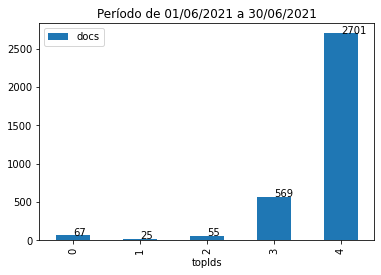





Calculando os 2 tópicos mais frequentes do período [01/07/2021 a 31/07/2021]
----------------------------------------
0 : ['militar', 'onu', 'ajudar', 'pensar', 'paise', 'coisa', 'entender', 'mandar', 'pedir', 'primeiro', 'lembrar', 'mau', 'roberto_dias', 'sair', 'precisar', 'olhar', 'brasileiro', 'missao', 'eua', 'situacao']
1 : ['primeiro_ministro', 'gente', 'moise', 'passar', 'pessoa', 'prender', 'crise', 'policia', 'antes', 'mercenario', 'morte', 'matar', 'colombiano', 'assassinato', 'jovenel_moise', 'grupo', 'matar_presidente', 'americano', 'morte_presidente', 'presidente']
2 : ['assassinato_presidente', 'governo', 'acontecer', 'ficar', 'primeiro_dama', 'venezuela', 'deixar', 'cia', 'estados_unidos', 'golpe', 'levar', 'usar', 'tempo', 'americo_latino', 'jovenel_moise', 'bolsonaro', 'colombiano', 'brasil', 'estar', 'mercenario']
3 : ['haitiano', 'cuba', 'eua', 'povo', 'mundo', 'contra', 'americano', 'grande', 'viver', 'revolucao', 'parecer', 'chegar', 'morte_presidente', 'estar

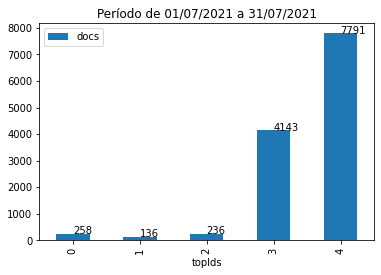





Calculando os 2 tópicos mais frequentes do período [01/08/2021 a 31/08/2021]
----------------------------------------
0 : ['brasil', 'mundo', 'chegar', 'eua', 'cuba', 'viver', 'paise', 'acabar', 'contra', 'levar', 'primeiro', 'enviar', 'problema', 'olhar', 'missao_humanitario', 'sismo', 'venezuela', 'guerra', 'afeganistao', 'humanitario']
1 : ['pessoa', 'atingir', 'ficar', 'apos_terremoto', 'terremoto_magnitude', 'matar', 'militar', 'onu', 'vida', 'morte', 'tempestade_tropical', 'terremoto_atingir', 'menos', 'exercito', 'momento', 'hora', 'ferir', 'deixar', 'magnitude', 'forca']
2 : ['haitiano', 'povo', 'brasileiro', 'presidente', 'governo', 'humanitario', 'bolsonaro', 'paz', 'contar', 'tempo', 'missao', 'forca', 'sair', 'ajudar_humanitario', 'militar', 'missao_humanitario', 'levar', 'enviar', 'politico', 'conseguir']
3 : ['afeganistao', 'ajudar', 'acontecer', 'gente', 'deixar', 'triste', 'precisar', 'pensar', 'populacao', 'coisa', 'mandar', 'lugar', 'tragedia', 'semana', 'heleno',

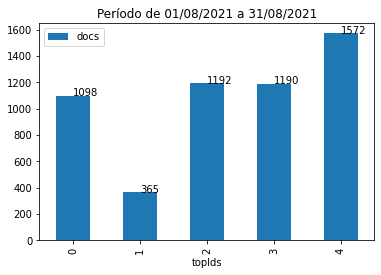





Calculando os 2 tópicos mais frequentes do período [01/09/2021 a 30/09/2021]
----------------------------------------
0 : ['povo', 'ficar', 'mundo', 'onu', 'paise', 'politico', 'cuba', 'primeiro', 'pensar', 'trabalho', 'lugar', 'pessoa', 'sofrer', 'problema', 'revolucao', 'franco', 'viver', 'precisar', 'estar', 'chamar']
1 : ['haiti', 'presidente', 'ajudar', 'terremoto', 'grande', 'pessoa', 'gente', 'venezuela', 'deixar', 'passar', 'mau', 'contra', 'coisa', 'caso', 'acontecer', 'sair', 'viver', 'tempo', 'estar', 'general']
2 : ['brasileiro', 'crianco', 'lembrar', 'haitiana', 'receber', 'eua_deportar', 'esperar', 'deportar', 'apoio', 'trump', 'general', 'migrante', 'continuar', 'crise', 'mandar', 'chegar', 'estados_unidos', 'missao', 'humanitario', 'viver']
3 : ['haitiano', 'eua', 'governo', 'biden', 'imigrante', 'acabar', 'chegar', 'enviar', 'pedir', 'americano', 'deportar', 'mandar', 'fronteira', 'migrante', 'voltar', 'mexico', 'estados_unidos', 'revolucao', 'entrar', 'trump']
4 :

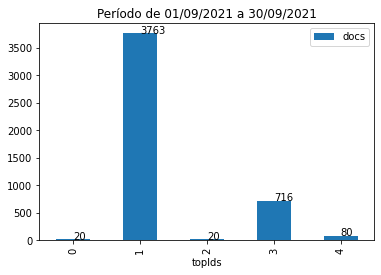





Calculando os 2 tópicos mais frequentes do período [01/10/2021 a 31/10/2021]
----------------------------------------
0 : ['ficar', 'grande', 'matar', 'fao', 'primeiro', 'projeto', 'conhecer', 'capital', 'voltar', 'apenas', 'antes', 'perguntar', 'entender', 'dever_ser', 'casa', 'caso', 'afeganistao', 'ganhar', 'pagar', 'pobre']
1 : ['haitiano', 'revolucao', 'militar', 'bolsonaro', 'enviar', 'escola', 'tentar', 'assassino_presidente', 'receber', 'caso', 'negro', 'casa', 'acabar', 'meio', 'presidente', 'americo', 'situacao', 'entrar', 'governo', 'chegar']
2 : ['haiti', 'brasil', 'eua', 'governo', 'pessoa', 'presidente', 'venezuela', 'americano', 'mundo', 'povo', 'cuba', 'ajudar', 'chegar', 'pedir', 'missionario', 'ganguir', 'familia', 'sequestrar', 'acabar', 'sao_sequestrar']
3 : ['argentina', 'paise', 'gente', 'mau', 'inflacao', 'venezuela', 'coisa', 'boliver', 'americo_latino', 'olhar', 'menos', 'americo', 'brasil', 'viver', 'ganhar', 'problema', 'apenas', 'precisar', 'cuba', 'gove

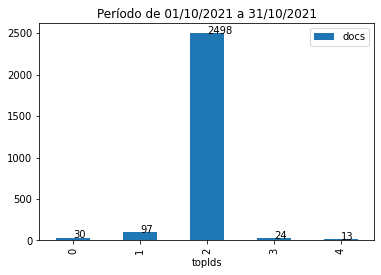





Calculando os 2 tópicos mais frequentes do período [01/11/2021 a 30/11/2021]
----------------------------------------
0 : ['venezuela', 'eua', 'politico', 'pai_pobre', 'americo_latino', 'precisar', 'ganhar', 'fechar', 'chegar', 'acabar', 'americo', 'defender', 'mundo', 'conseguir', 'lula', 'morar', 'mau', 'venezuelano', 'brasil', 'lugar']
1 : ['gente', 'chegar', 'heleno', 'deixar', 'ajudar', 'acabar', 'pensar', 'acontecer', 'estar', 'matar', 'antes', 'conhecer', 'ouvir', 'precisar', 'vida', 'entrar', 'coisa', 'primeiro', 'missao', 'perder']
2 : ['haitiano', 'revolucao', 'pessoa', 'venezuelano', 'sair', 'entrar', 'seguir', 'morar', 'casa', 'negro', 'contar', 'primeiro', 'perder', 'chamar', 'levar', 'tempo', 'coisa', 'lembrar', 'brasileiro', 'mundo']
3 : ['haiti', 'brasil', 'brasileiro', 'grande', 'mundo', 'ficar', 'povo', 'lula', 'negro', 'paise', 'militar', 'contra', 'onu', 'mau', 'lembrar', 'vida', 'coisa', 'caso', 'mandar', 'lugar']
4 : ['governo', 'general', 'presidente', 'cuba'

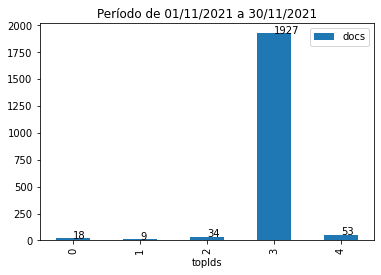





Calculando os 2 tópicos mais frequentes do período [01/12/2021 a 31/12/2021]
----------------------------------------
0 : ['pessoa', 'povo', 'ajudar', 'explosao_caminhao', 'conseguir', 'lugar', 'senhor', 'assassinar', 'crianco', 'trabalhar', 'morte', 'presidente', 'matar', 'precisar', 'primeiro', 'argentina', 'governo', 'missionario', 'pedir', 'antes']
1 : ['venezuela', 'passar', 'pai_pobre', 'coisa', 'tornar', 'mandar', 'america', 'americo_latino', 'entender', 'tempo', 'argentina', 'haitiana', 'negro', 'amigo', 'mundo', 'acabar', 'ganhar', 'conhecer', 'deixar', 'virar']
2 : ['ficar', 'heleno', 'matar', 'general', 'paise', 'pobre', 'militar', 'deixar', 'levar', 'contra', 'sair', 'caso', 'massacre', 'viver', 'pagar', 'continuar', 'apenas', 'missionario', 'historia', 'precisar']
3 : ['haitiano', 'brasil', 'lula', 'brasileiro', 'governo', 'presidente', 'mundo', 'cuba', 'revolucao', 'acontecer', 'lembrar', 'acabar', 'mau', 'onu', 'olhar', 'primeiro', 'politico', 'menos', 'virar', 'esta

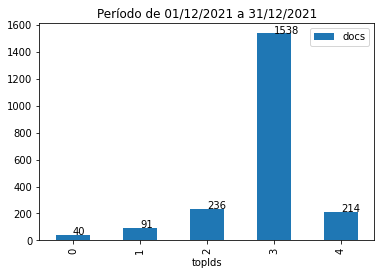





Calculando os 2 tópicos mais frequentes do período [01/01/2022 a 31/01/2022]
----------------------------------------
0 : ['haiti', 'brasil', 'eua', 'presidente', 'ficar', 'pessoa', 'mundo', 'terremoto', 'governo', 'independencia', 'lula', 'deixar', 'lembrar', 'chamar', 'lugar', 'matar', 'mandar', 'historia', 'assassinato_presidente', 'viver']
1 : ['primeiro_ministro', 'usar', 'passar', 'sair', 'chegar', 'entrar', 'coisa', 'ariel_henry', 'contar', 'imigrante', 'voltar', 'contra', 'tentar', 'ficar', 'precisar', 'governo', 'deixar', 'parecer', 'video', 'estar']
2 : ['cuba', 'paise', 'brasileiro', 'argentina', 'primeiro', 'gente', 'venezuela', 'americo_latino', 'pequeno', 'populacao', 'menos', 'ilha', 'vacinar', 'inflacao', 'americo_latina', 'comparar', 'africar', 'paises', 'americano', 'perder']
3 : ['contra', 'povo', 'militar', 'bolsonaro', 'pobre', 'venezuela', 'selecao', 'rico', 'ajudar', 'brasileiro', 'tornar', 'branco', 'mulher', 'poder_ser', 'tempo', 'negro', 'viver', 'governo'

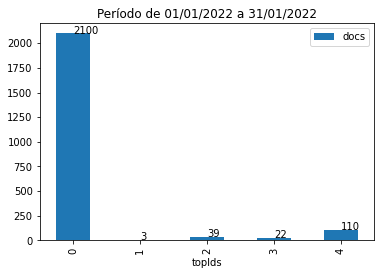

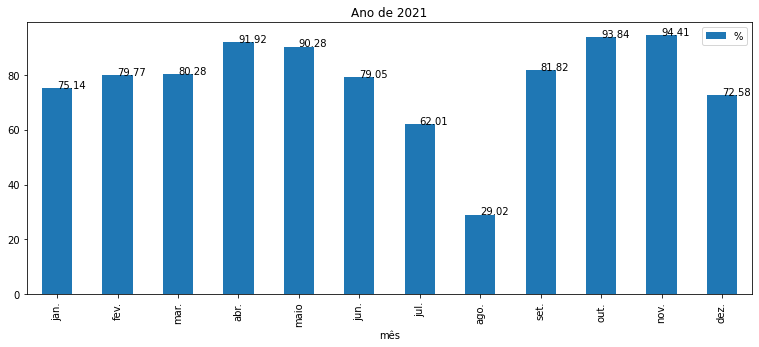




Calculando os 2 tópicos mais frequentes do período [01/02/2022 a 28/02/2022]
----------------------------------------
0 : ['brasileiro', 'gente', 'militar', 'governo', 'onu', 'negro', 'primeiro', 'pensar', 'lula', 'matar', 'precisar', 'deixar', 'exercito', 'general', 'missao_paz', 'estar', 'pobre', 'heleno', 'capitalista', 'morrer']
1 : ['africar', 'pessoa', 'comentario', 'grande', 'presidente', 'responder', 'pessoal', 'colocar', 'todo_mundo', 'politico', 'trabalhar', 'trabalho', 'citar', 'pedir', 'povo', 'americano', 'pensar', 'conseguir', 'morrer', 'jamaica']
2 : ['brasil', 'eua', 'cuba', 'guerra', 'mundo', 'paise', 'venezuela', 'lembrar', 'congo', 'ucrania', 'contra', 'sair', 'acabar', 'conseguir', 'tempo', 'afeganistao', 'russia', 'comecar', 'republico_dominicano', 'entrar']
3 : ['ficar', 'povo', 'jamaica', 'ficar_africo', 'ajudar', 'passar', 'mandar', 'mau', 'vida', 'perguntar', 'americo_central', 'amigo', 'americo', 'hondura', 'chegar', 'haitiana', 'conhecer', 'forma', 'iraque

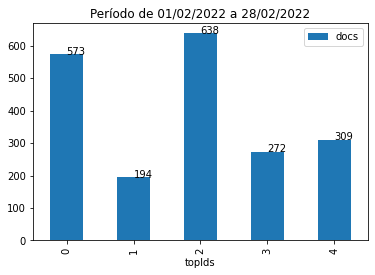





Calculando os 2 tópicos mais frequentes do período [01/03/2022 a 31/03/2022]
----------------------------------------
0 : ['onu', 'lembrar', 'crianco', 'primeiro', 'terremoto', 'verdade', 'ganhar', 'proprio', 'histor', 'general_heleno', 'mulher', 'filho', 'presidente', 'entrar', 'esquecer', 'sofrer', 'deixar', 'revolucao', 'caso', 'inclusive']
1 : ['haitiano', 'passar', 'negro', 'imigrante', 'chamar', 'ucraniano', 'conseguir', 'venezuelano', 'perguntar', 'trabalho', 'refugiar', 'amigo', 'inclusive', 'receber', 'branco', 'chegar', 'trabalhar', 'acabar', 'pegar', 'parecer']
2 : ['ajudar', 'mulher', 'pobre', 'lugar', 'mau', 'apenas', 'outro_paise', 'presidente', 'parte', 'filho', 'americo_latino', 'politico', 'conflito', 'continuar', 'europa', 'sofrer', 'chegar', 'tempo', 'pensar', 'guerra']
3 : ['mundo', 'ficar', 'paise', 'militar', 'governo', 'lula', 'contra', 'coisa', 'invadir', 'congo', 'general', 'usar', 'bolsonaro', 'diferente', 'heleno', 'invasao', 'entrar', 'igual', 'humanitar

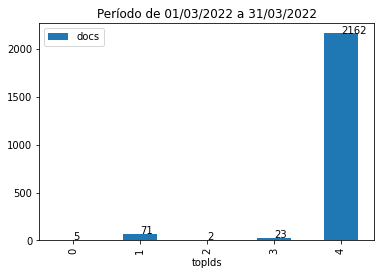





Calculando os 2 tópicos mais frequentes do período [01/04/2022 a 30/04/2022]
----------------------------------------
0 : ['brasil', 'eua', 'grande', 'guerra', 'mundo', 'cuba', 'paise', 'contra', 'deixar', 'missao', 'africar', 'pensar', 'tempo', 'vida', 'amigo', 'jamaica', 'capitalista', 'afeganistao', 'ajudar', 'missao_paz']
1 : ['haitiano', 'revolucao', 'imigrante', 'chegar', 'mau', 'venezuelano', 'trabalhar', 'chamar', 'tomar', 'olhar', 'comecar', 'ajudar', 'realmente', 'historia', 'vida', 'morar', 'lingua', 'primeiro', 'morrer', 'amigo']
2 : ['gente', 'negro', 'matar', 'heleno', 'igual', 'precisar', 'politico', 'colocar', 'acontecer', 'verdade', 'branco', 'contar', 'estar', 'americano', 'historio', 'inclusive', 'imaginar', 'cidade', 'regiao', 'morar']
3 : ['haiti', 'brasileiro', 'ficar', 'pessoa', 'povo', 'coisa', 'passar', 'venezuela', 'conseguir', 'servir', 'parecer', 'haitiana', 'usar', 'mandar', 'primeiro', 'populacao', 'virar', 'existir', 'sair', 'viver']
4 : ['militar', '

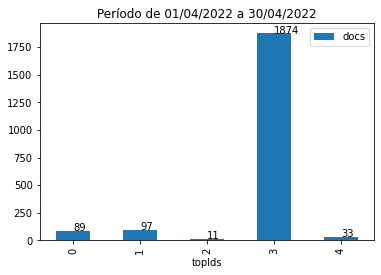





Calculando os 2 tópicos mais frequentes do período [01/05/2022 a 31/05/2022]
----------------------------------------
0 : ['haitiano', 'ficar', 'povo', 'revolucao', 'guerra', 'lembrar', 'coisa', 'acabar', 'acontecer', 'branco', 'passar', 'trabalho', 'exercito', 'pobre', 'verdade', 'sair', 'igual', 'olhar', 'politico', 'estar']
1 : ['mundo', 'presidente', 'crescer', 'primeiro', 'pequeno', 'conseguir', 'independencia', 'pensar', 'deixar', 'ajudar', 'casa', 'virar', 'tempo', 'conhecer', 'violencia', 'receber', 'porto_principe', 'ganhar', 'vergonha', 'sao_paulo']
2 : ['lula', 'eua', 'contra', 'militar', 'heleno', 'general', 'amigo', 'viver', 'chegar', 'golpe', 'contar', 'existir', 'massacre', 'general_heleno', 'crime', 'menos', 'tarcisio', 'brasileiro', 'governo', 'cuba']
3 : ['brasil', 'venezuela', 'bolsonaro', 'cuba', 'paise', 'mau', 'franco', 'gente', 'grande', 'governo', 'pagar', 'argentina', 'mal', 'atra', 'americo_latino', 'pib', 'senhor', 'perguntar', 'terremoto', 'colocar']
4 :

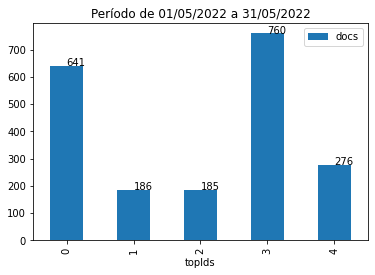

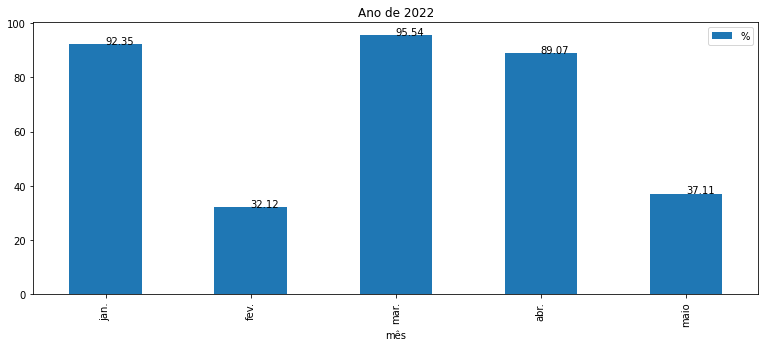

In [ ]:

prev_year = None
dic_plot_data_per_year = {'months': [], 'percents': []}

len_df = len(df)

for idx in range(len_df):
  #if idx > 15: break
  start_period, end_period = get_tweets_period(idx, df)
  period = str(start_period+'_'+end_period).replace('/','_')
  print(f'Calculando os 2 tópicos mais frequentes do período [{start_period} a {end_period}]')   
  print('-'*40)

  df_dominant_t = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/TCC/csv/lda_copy/__docs__{period}__.csv', lineterminator='\n')
  df_dominant_t.topics__num__prob__keywords = df_dominant_t.topics__num__prob__keywords.apply(literal_eval)
 
  list_of_dict, list_aux, dic_count_aux = [], [], {}

  #contar o numero de tópicos
  docs = df_dominant_t.values.tolist()
  for i, doc in enumerate(docs):
    
    topic_infos = doc[2]
    for top_inf in topic_infos:
      if top_inf[0] in list_aux:
          index = list_aux.index(top_inf[0])
          list_of_dict[index]['count'] += 1
      else:  
          dic_count_aux = {'num_top': top_inf[0], 'count':1, 'key_words': top_inf[2]} 
          list_aux.append(top_inf[0])
          list_of_dict.append(dic_count_aux)

  LDA = LdaModel.load(f"/content/drive/My Drive/Colab Notebooks/TCC/lda_copy/period_{period}_k_topic_{k}.bin")
  topics = LDA.show_topics(num_words=20)

  #print(topics)
  for i, top in enumerate(topics):
    topic = (''.join([word.strip() for word in top[1] if not word.isdigit() and word not in invalid_print_chars])).split('+')
    print(f'{i} : {topic}')
  print('-'*250)
  print()

  # #print(f'Tópicos com mais documentos associados')
  sort_by_count = sorted(list_of_dict, key=operator.itemgetter('count'), reverse=True)
  count_doc = 0
  for highest in sort_by_count:
    print(f'Id: {highest["num_top"]}, Docs: {highest["count"]}, Keywords: [{highest["key_words"]}]')
    count_doc += highest["count"]  

  print('*'*250) 

  #gráfico com matplotlib
  dic_plot_data = {'topIds': [],'docs': []}
 
  for highest in sorted(list_of_dict, key=operator.itemgetter('num_top')):
    dic_plot_data["topIds"].append(highest["num_top"])
    dic_plot_data["docs"].append(highest["count"])

  sub_df = pd.DataFrame({'topIds':dic_plot_data["topIds"], 'docs':dic_plot_data["docs"]})
  sub_df.plot(kind='bar', x='topIds', y='docs', title=f'Período de {start_period} a {end_period}')

  for index, value in enumerate(list(sub_df["docs"])):
    plt.text(index, value, str(value))

  plt.show()
  print()



  #--------------plot data by year--------------------
  percent = round((sort_by_count[0]["count"] * 100 / count_doc), 2)
 
  date_info = datetime.datetime.strptime(start_period, "%d/%m/%Y")
  current_year = date_info.year
  month_index = date_info.month

  month = months[str(month_index)]

  if (prev_year != current_year and prev_year is not None) or idx == (len_df - 1):
    if idx == (len_df - 1):
      dic_plot_data_per_year["months"].append(month)
      dic_plot_data_per_year["percents"].append(percent)
      label_year = current_year
    else:
      label_year = prev_year

    sub_df_y = pd.DataFrame({'mês':dic_plot_data_per_year["months"], '%':dic_plot_data_per_year["percents"]})
    sub_df_y.plot(kind='bar', x='mês', y='%', figsize=(13, 5), title=f'Ano de {label_year}')

    for index, value in enumerate(list(sub_df_y["%"])):
      plt.text(index, value, str(value))

    plt.show()

    dic_plot_data_per_year = {'months': [], 'percents': []}

  dic_plot_data_per_year["months"].append(month)
  dic_plot_data_per_year["percents"].append(percent)
  prev_year = current_year
  #--------------end plot data by year--------------------

  print('\n\n')


In [ ]:
dftweets['datetime']

,datetime,tweet_id,user_id,text,count_word,text_preprocessed,text_lematizados,bigrams_lem,text_stematizados,bigrams_stem
1,2022-05-30 23:00:53+00:00,1531410348141592577,1473798922472767488,@BetoLuiz_RU @jonesmanoel_PCB @deccache O Hait...,16,haiti desgraca fato erros anulam acertos fala ...,haiti desgracar fato erro anular acerto falar ...,haiti desgracar fato erro anular acerto falar ...,hait desgrac fat err anul acert fal sobr guerr...,hait desgrac fat err anul acert fal sobr guerr...
2,2022-05-30 22:57:20+00:00,1531409451122577410,1521912766151417856,O senhor vai investir na educação da Venezuela...,17,senhor vai investir educacao venezuela argenti...,senhor ir investir educacao venezuela argentin...,senhor ir investir_educacao venezuela argentin...,senh vai invest educaca venezuel argentin hait...,senh vai invest_educaca venezuel argentin hait...
3,2022-05-30 22:55:14+00:00,1531408925945434112,1253882714723409920,"@rsallesmma Que nada, na mão de vocês já tá vi...",8,nada mao voces virando mistura deserto saara h...,nada mao voce virar mistura deserto saara haiti,nada mao voce virar_mistura deserto saara haiti,nad mao voc vir mist desert sa hait,nad mao voc vir_mist desert_sa hait
4,2022-05-30 22:55:14+00:00,1531408923277807617,40320768,@JoppertLeonardo @jonesmanoel_PCB @deccache En...,23,entramos brics invadimos haiti mando bush lula...,entra brics invadir haiti mar bush lula dizer ...,entra brics invadir haiti mar_bush lula dizer ...,entr bric invad hait mand bush lul diz vai for...,entr bric invad hait mand bush lul diz vai for...
5,2022-05-30 22:37:49+00:00,1531404543568781313,1082697350441824257,"@alice_mader9 kkkkkk e era 2 haitiano, n enten...",4,haitiano entendi nada falavam,haitiano entendi nada falar,haitiano entendi_nada falar,haiti entend nad fal,haiti entend_nad fal
...,...,...,...,...,...,...,...,...,...,...
185341,2018-01-01 11:33:11+00:00,947792815668514816,896213196310183936,@UOL @jlgoncalez E os BRASILEIROS Q MORREM DE ...,22,brasileiros morrem fome brasileiros inocentes ...,brasileiro morr fome brasileiro inocente polic...,brasileiro morr_fome brasileiro inocente polic...,brasil morr fom brasil inoc polic mat bal perd...,brasil morr_fom brasil inoc polic mat bal_perd...
185342,2018-01-01 11:27:30+00:00,947791387797393408,182945726,@diogomainardi Quem merece uma homenagem é a m...,15,merece homenagem medica sanitarista zilda arns...,merecer homenagem medico sanitarista zilda arn...,merecer homenagem medico_sanitarista zilda_arn...,merec homen medic sanitar zild arm presid past...,merec homen medic_sanitar zild_arm presid past...
185345,2018-01-01 04:46:44+00:00,947690530498138112,2654726438,https://t.co/1k54jvSxHj\n\nRÉGINE MINHA FADA D...,5,regine fada haiti escolhi amar,regine far haiti escolher amar,regine far haiti escolher amar,regin fad hait escolh am,regin fad hait escolh am
185346,2018-01-01 01:10:25+00:00,947636095033970688,784508732969512960,@lmjrosez axanei de dedcobir q sei falat haitiano,5,axanei dedcobir sei falat haitiano,axanar dedcobir saber falat haitiano,axanar dedcobir saber falat haitiano,axan dedcob sei falat haiti,axan dedcob sei falat haiti
